#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.

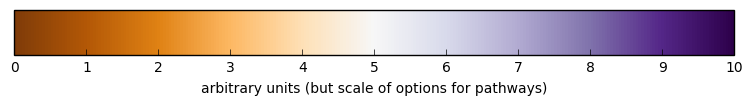

In [1]:
if True:
    #this will work to reload whatever I had
    import dill
    dill.load_session('globalsave.pkl')

In [1]:
if True:
    %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? ye
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [25]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb
from sklearn import preprocessing
import seaborn as sns

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

from scipy.cluster import hierarchy as hc

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [26]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.07.31_v1.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabNames = pd.read_csv(mtabFile,index_col = 'KEGG',usecols = ['KEGG','mtabNames'])
mtabNames.head(3)

mtabNames
KEGG                                  
C00196       2-3-dihydroxybenzoic acid
C19675  2-3-dihydroxypropane1sulfonate
C08276          3-mercapto proprionate

In [27]:
#take out the extra columns: 
mtabData.drop(['extEff','mtabNames'],axis = 1,inplace = True)
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [28]:
mtabData.head()

Plimited_extracellular_s9301ax_50  Plimited_filter_s9301ax_50  \
KEGG                                                                    
C00196                       0.000000e+00                         0.0   
C19675                       1.500000e-09                         0.0   
C08276                       0.000000e+00                         0.0   
C00141                       1.490000e-06                         0.0   
C00671                       0.000000e+00                         0.0   

        replete_extracellular_s9301ax_10  replete_extracellular_s9301ax_50  \
KEGG                                                                         
C00196                      0.000000e+00                      0.000000e+00   
C19675                      7.560000e-09                      0.000000e+00   
C08276                      0.000000e+00                      0.000000e+00   
C00141                      1.260000e-06                      1.700000e-06   
C00671                      1.150000e-07                      2.140000e-07   

        replete_extracellular_s0801ax_10  replete_extracellular_s9313ax_5  \
KEGG                                                                        
C00196                      0.000000e+00                     0.000000e+00   
C19675                      8.830000e-09                     0.000000e+00   
C08276                      0.000000e+00                     0.000000e+00   
C00141                      3.660000e-08                     1.370000e-05   
C00671                      0.000000e+00                     6.080000e-07   

        replete_extracellular_s9313ax_10  replete_filter_s9301ax_10  \
KEGG                                                                  
C00196                      0.000000e+00               0.000000e+00   
C19675                      0.000000e+00               0.000000e+00   
C08276                      0.000000e+00               0.000000e+00   
C00141                      1.170000e-05               0.000000e+00   
C00671                      6.060000e-07               1.500000e-09   

        replete_filter_s9301ax_50  replete_filter_s0801ax_10  \
KEGG                                                           
C00196               0.000000e+00               0.000000e+00   
C19675               0.000000e+00               0.000000e+00   
C08276               0.000000e+00               0.000000e+00   
C00141               0.000000e+00               0.000000e+00   
C00671               1.230000e-09               2.170000e-09   

        replete_filter_s9313ax_5  replete_filter_s9313ax_10  
KEGG                                                         
C00196              0.000000e+00               0.000000e+00  
C19675              0.000000e+00               0.000000e+00  
C08276              0.000000e+00               0.000000e+00  
C00141              0.000000e+00               0.000000e+00  
C00671              1.410000e-10               2.190000e-09

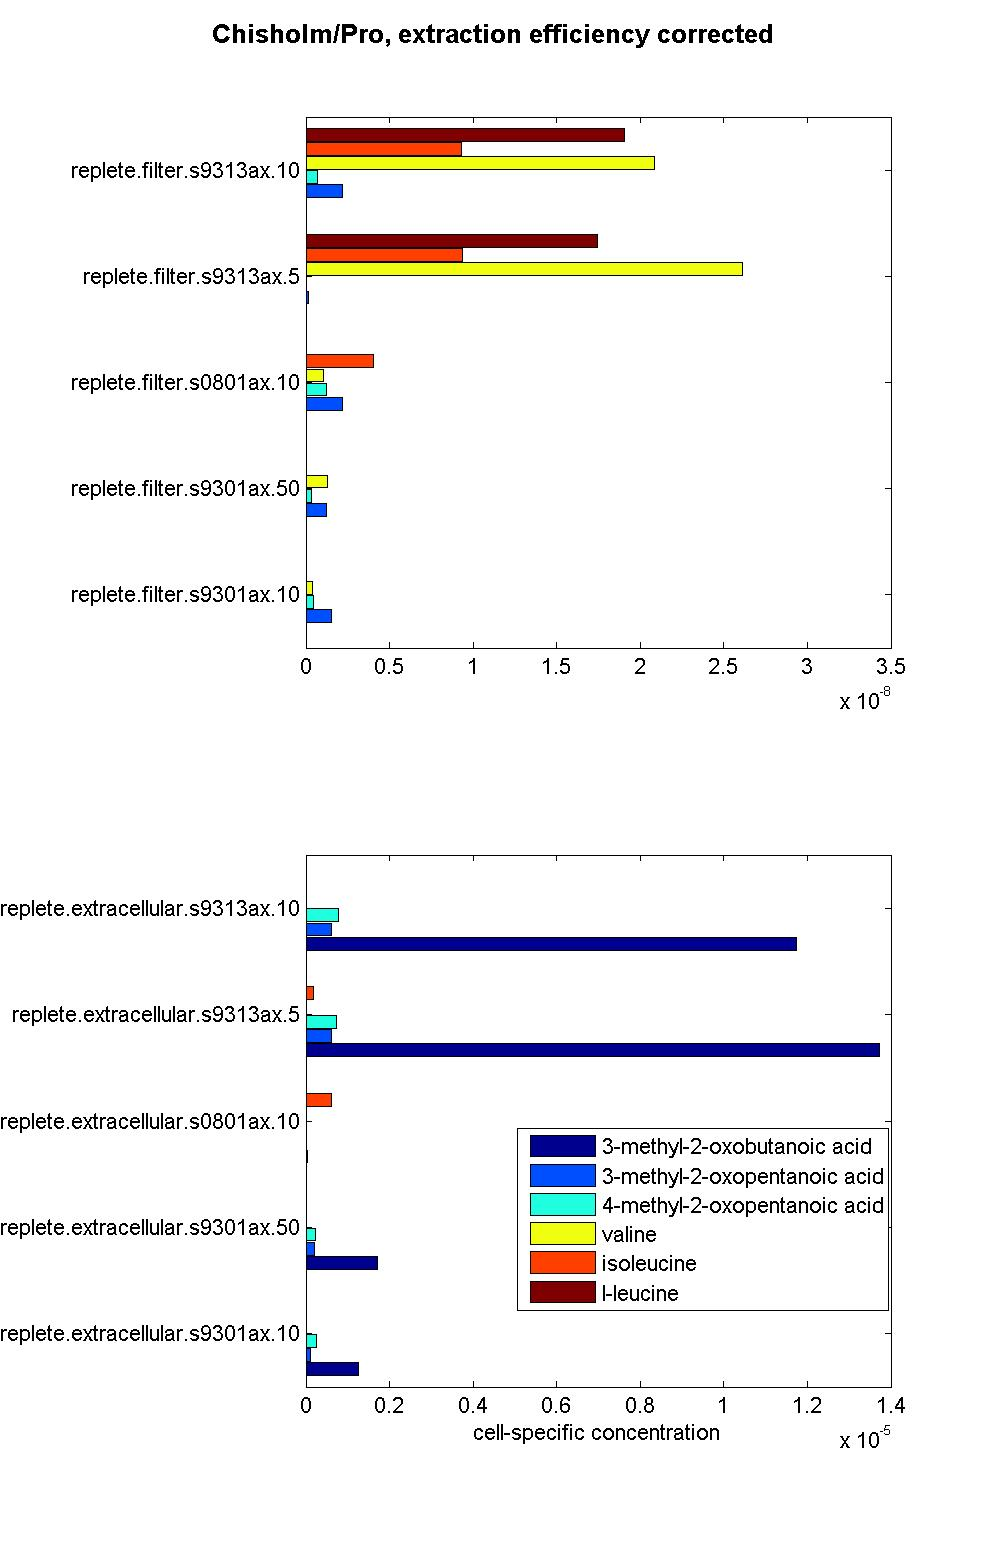

In [29]:
#read in the bar graph with the new acids (from MATLAB)
from IPython.display import Image
Image("Chisholm_Pro_newAcids.2017.04.27.jpg",width=300, height=300)

Setup a few useful functions
---

In [30]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [31]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [32]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [33]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [34]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimMap(importString):
    export_trimMap = []
    current_section = None
    for line in importString.rstrip().split("\n"):
        r = line.find('map')
        tp = line[r : r+9]
        export_trimMap.append(tp)
    return export_trimMap

#trim a pathway/compound list
def trimCompounds(cpdString):
    export_trimCpds = []
    current_section = None
    for line in cpdString.rstrip().split("\n"):
        #print(line)
        r = line.find('cpd')
        tp = line[r + 4 : len(line)]
        export_trimCpds.append(tp)
    return export_trimCpds

#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

In [35]:
#bring in the plotting functions
import plotByGroup
#import fxn_plotPathway #with ratios...but other errors in there
import fxn_plotPathway_v2
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

First, do statistics to see about differences across groups. Since light is 'usually' not
a factor, do the analysis with the same light level across strains (light = 10) and
only considering filters for now.

26 June 2017

In [36]:
mtabData.head()

Plimited_extracellular_s9301ax_50  Plimited_filter_s9301ax_50  \
KEGG                                                                    
C00196                       0.000000e+00                         0.0   
C19675                       1.500000e-09                         0.0   
C08276                       0.000000e+00                         0.0   
C00141                       1.490000e-06                         0.0   
C00671                       0.000000e+00                         0.0   

        replete_extracellular_s9301ax_10  replete_extracellular_s9301ax_50  \
KEGG                                                                         
C00196                      0.000000e+00                      0.000000e+00   
C19675                      7.560000e-09                      0.000000e+00   
C08276                      0.000000e+00                      0.000000e+00   
C00141                      1.260000e-06                      1.700000e-06   
C00671                      1.150000e-07                      2.140000e-07   

        replete_extracellular_s0801ax_10  replete_extracellular_s9313ax_5  \
KEGG                                                                        
C00196                      0.000000e+00                     0.000000e+00   
C19675                      8.830000e-09                     0.000000e+00   
C08276                      0.000000e+00                     0.000000e+00   
C00141                      3.660000e-08                     1.370000e-05   
C00671                      0.000000e+00                     6.080000e-07   

        replete_extracellular_s9313ax_10  replete_filter_s9301ax_10  \
KEGG                                                                  
C00196                      0.000000e+00               0.000000e+00   
C19675                      0.000000e+00               0.000000e+00   
C08276                      0.000000e+00               0.000000e+00   
C00141                      1.170000e-05               0.000000e+00   
C00671                      6.060000e-07               1.500000e-09   

        replete_filter_s9301ax_50  replete_filter_s0801ax_10  \
KEGG                                                           
C00196               0.000000e+00               0.000000e+00   
C19675               0.000000e+00               0.000000e+00   
C08276               0.000000e+00               0.000000e+00   
C00141               0.000000e+00               0.000000e+00   
C00671               1.230000e-09               2.170000e-09   

        replete_filter_s9313ax_5  replete_filter_s9313ax_10  
KEGG                                                         
C00196              0.000000e+00               0.000000e+00  
C19675              0.000000e+00               0.000000e+00  
C08276              0.000000e+00               0.000000e+00  
C00141              0.000000e+00               0.000000e+00  
C00671              1.410000e-10               2.190000e-09

In [37]:
mtabPruned.head()

Plimited_extracellular_s9301ax_50  Plimited_filter_s9301ax_50  \
KEGG                                                                    
C00196                       0.000000e+00                         0.0   
C19675                       1.500000e-09                         0.0   
C08276                       0.000000e+00                         0.0   
C00141                       1.490000e-06                         0.0   
C00671                       0.000000e+00                         0.0   

        replete_extracellular_s9301ax_10  replete_extracellular_s9301ax_50  \
KEGG                                                                         
C00196                      0.000000e+00                      0.000000e+00   
C19675                      7.560000e-09                      0.000000e+00   
C08276                      0.000000e+00                      0.000000e+00   
C00141                      1.260000e-06                      1.700000e-06   
C00671                      1.150000e-07                      2.140000e-07   

        replete_extracellular_s0801ax_10  replete_extracellular_s9313ax_5  \
KEGG                                                                        
C00196                      0.000000e+00                     0.000000e+00   
C19675                      8.830000e-09                     0.000000e+00   
C08276                      0.000000e+00                     0.000000e+00   
C00141                      3.660000e-08                     1.370000e-05   
C00671                      0.000000e+00                     6.080000e-07   

        replete_extracellular_s9313ax_10  replete_filter_s9301ax_10  \
KEGG                                                                  
C00196                      0.000000e+00               0.000000e+00   
C19675                      0.000000e+00               0.000000e+00   
C08276                      0.000000e+00               0.000000e+00   
C00141                      1.170000e-05               0.000000e+00   
C00671                      6.060000e-07               1.500000e-09   

        replete_filter_s9301ax_50  replete_filter_s0801ax_10  \
KEGG                                                           
C00196               0.000000e+00               0.000000e+00   
C19675               0.000000e+00               0.000000e+00   
C08276               0.000000e+00               0.000000e+00   
C00141               0.000000e+00               0.000000e+00   
C00671               1.230000e-09               2.170000e-09   

        replete_filter_s9313ax_5  replete_filter_s9313ax_10  
KEGG                                                         
C00196              0.000000e+00               0.000000e+00  
C19675              0.000000e+00               0.000000e+00  
C08276              0.000000e+00               0.000000e+00  
C00141              0.000000e+00               0.000000e+00  
C00671              1.410000e-10               2.190000e-09

In [38]:
#let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

In [39]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head(3)

map           A                         B  \
10  01100  Metabolism  Global and overview maps   
11  01110  Metabolism  Global and overview maps   
12  01120  Metabolism  Global and overview maps   

                                               C  \
10                            Metabolic pathways   
11         Biosynthesis of secondary metabolites   
12  Microbial metabolism in diverse environments   

                                           wholeThing  
10                   C    01100  Metabolic pathways\n  
11  C    01110  Biosynthesis of secondary metaboli...  
12  C    01120  Microbial metabolism in diverse en...

In [40]:
prunedBRITE[prunedBRITE.loc[:,'map']=='00410'] #check one

map           A                                B  \
81  00410  Metabolism  Metabolism of other amino acids   

                          C                             wholeThing  
81  beta-Alanine metabolism  C    00410  beta-Alanine metabolism\n

In [41]:
#only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [42]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [43]:
#let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

Plot the metabolite concentration by group
---

In [44]:
#can plot one at a time (change strain, 3-digit KEGG code, and light level)
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_10']
fxn_plotPathway_v2.gatherDetails('pmg00020','filter_plots',useCO,CO_values)

CO_values = mtabPruned.loc[:,'replete_extracellular_s9301ax_10']
fxn_plotPathway_v2.gatherDetails('pmg00020','extracellular_plots',useCO,CO_values)

In [45]:
#can plot one at a time
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s9313ax_5']
fxn_plotPathway_v2.gatherDetails('pmt00020','filter_plots',useCO,CO_values)

CO_values = mtabPruned.loc[:,'replete_extracellular_s9313ax_5']
fxn_plotPathway_v2.gatherDetails('pmt00020','extracellular_plots',useCO,CO_values)

In [46]:
#can plot one at a time
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'replete_filter_s0801ax_10']
fxn_plotPathway_v2.gatherDetails('prm00020','filter_plots',useCO,CO_values)

CO_values = mtabPruned.loc[:,'replete_extracellular_s0801ax_10']
fxn_plotPathway_v2.gatherDetails('prm00020','extracellular_plots',useCO,CO_values)

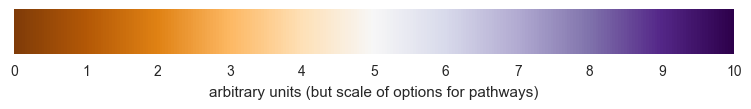

In [47]:
#...use the colorbar shown below for the pathway maps, though will set green to zero
import colorbar_only
#reload(colorbar_only)
#this will be the range of colors in the pathway maps (PDF files) (not green bc genes are green)

In [48]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'pmg'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway_v2.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)
                

In [49]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'pmt'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s9313ax_10']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway_v2.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

In [50]:
#plot the pathway maps for one strain and one set of data
oneStrain = 'prm'
useCO = mtabPruned.index

#set CO_values only for the pathway maps...(only plot one group at a time there)
#CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  
CO_values = mtabPruned.loc[:,'replete_filter_s0801ax_10']  

if False:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway_v2.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

In [51]:
unMetabolismGroups

array(['Carbohydrate metabolism', 'Energy metabolism', 'Lipid metabolism',
       'Nucleotide metabolism', 'Amino acid metabolism',
       'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [52]:
pathwayInfo = pd.DataFrame({'pGroup' : unMetabolismGroups,'nCpds' : np.nan,'nMeasure': np.nan})

In [53]:
pathwayInfo

nCpds  nMeasure                                       pGroup
0     NaN       NaN                      Carbohydrate metabolism
1     NaN       NaN                            Energy metabolism
2     NaN       NaN                             Lipid metabolism
3     NaN       NaN                        Nucleotide metabolism
4     NaN       NaN                        Amino acid metabolism
5     NaN       NaN              Metabolism of other amino acids
6     NaN       NaN           Glycan biosynthesis and metabolism
7     NaN       NaN         Metabolism of cofactors and vitamins
8     NaN       NaN     Metabolism of terpenoids and polyketides
9     NaN       NaN  Biosynthesis of other secondary metabolites
10    NaN       NaN    Xenobiotics biodegradation and metabolism
11    NaN       NaN       Chemical structure transformation maps

In [54]:
useCO = mtabPruned.index
ProData= set(useCO)

for oneGroup in unMetabolismGroups:
    shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)]
    onePath = shortList.loc[:,'map']
    onePath_ann=[]

    gatherAll = list()
    gatherPro = pd.DataFrame()
    
    for item in onePath:
        #onePath_ann.append('ko' + item)
        usePathway = 'ko' + item
        try:
            mCpds = set(getCfrom_ko(usePathway))
        except:
            print('invalid pathway at KEGG: ' + usePathway)

        #first, gather all compounds...
        for cpd in mCpds:
            if (cpd in gatherAll): #don't add to list if already there
                pass
            else:
                gatherAll.append(cpd)

        #now only count the ones in Pro
        handh = mCpds.intersection(ProData)
        for cpd in handh:
            tm = mtabPruned.loc[cpd,:]
            if (cpd in gatherPro.index): 
                pass
            else: #only add the mtab if it is new...can have mtabs in multiple pathways
                gatherPro = gatherPro.append(tm)

    pathwayInfo.loc[(pathwayInfo['pGroup']==oneGroup),'nCpds'] = len(gatherAll)
    pathwayInfo.loc[(pathwayInfo['pGroup']==oneGroup),'nMeasure'] = len(gatherPro)
    
    #export the list of compounds in each group for MATLAB
    eDF = pd.DataFrame(gatherPro)
    eDF.to_csv('compoundList_' + oneGroup + '.csv')

invalid pathway at KEGG: ko00351
invalid pathway at KEGG: ko01010
invalid pathway at KEGG: ko01060
invalid pathway at KEGG: ko01061
invalid pathway at KEGG: ko01062
invalid pathway at KEGG: ko01063
invalid pathway at KEGG: ko01064
invalid pathway at KEGG: ko01065
invalid pathway at KEGG: ko01066
invalid pathway at KEGG: ko01070


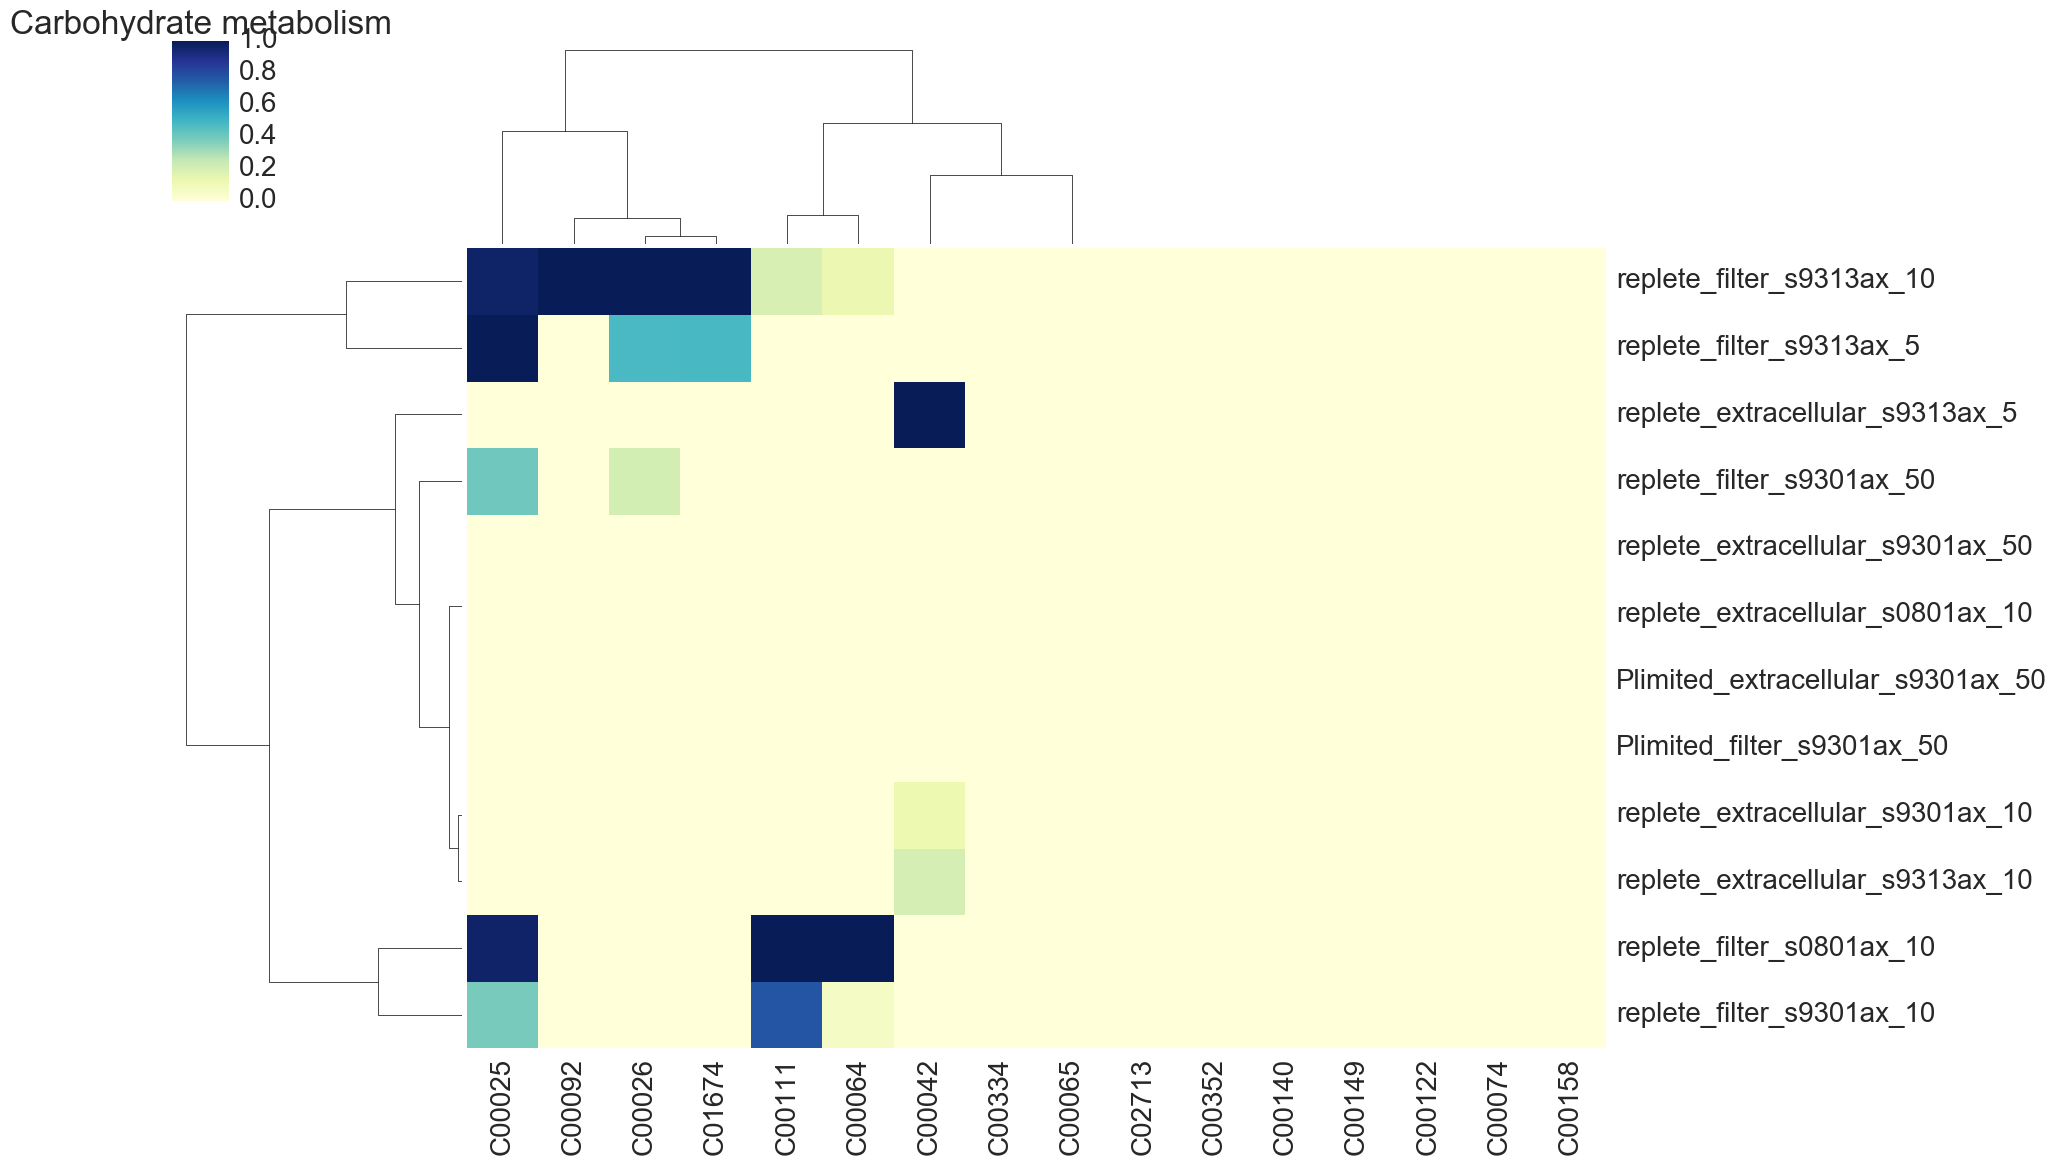

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00026	2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutaric acid; alpha-Ketoglutaric acid

cpd:C00042	Succinate; Succinic acid; Butanedionic acid; Ethylenesuccinic acid

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00074	Phosphoenolpyruvate; Phosphoenolpyruvic acid; PEP

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00122	Fumarate; Fumaric acid; trans-Butenedioic acid

cpd:C00140	N-Acetyl-D-glucosamine; N-Acetylchitosamine; 2-Acetamido-2-deoxy-D-glucose; GlcNAc

cpd:C00149	(S)-Malate; L-Malate; L-Apple acid; L-Malic acid; L-2-Hydroxybutanedioic acid; Malate; Malic acid

cpd:C00158	Citrate; Citric acid; 2-Hydroxy-1,2,3-propanetricarboxylic acid; 2-Hydroxytricarballylic acid

cpd:C00334	4-Aminobutanoate; 

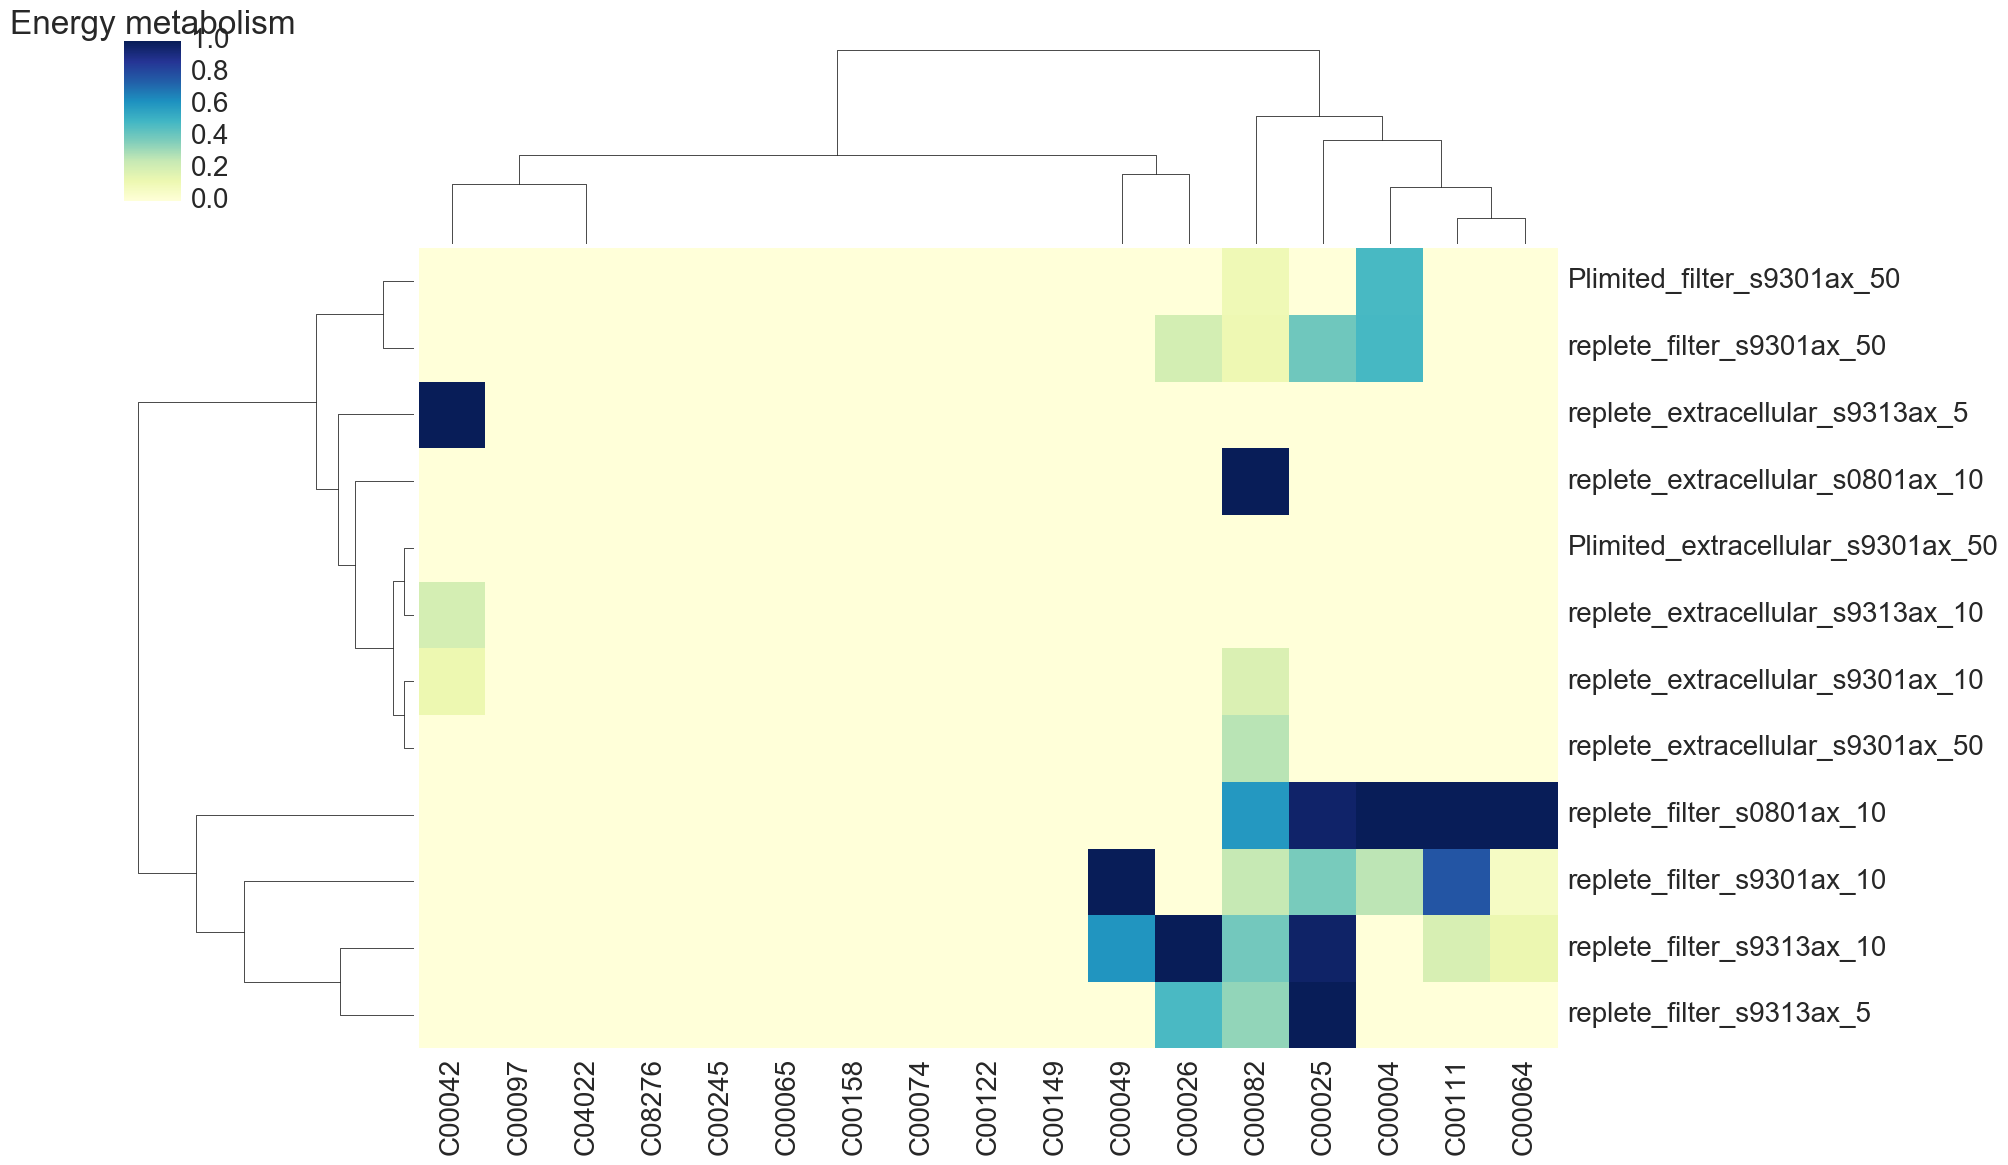

cpd:C00004	NADH; DPNH; Reduced nicotinamide adenine dinucleotide

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00026	2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutaric acid; alpha-Ketoglutaric acid

cpd:C00042	Succinate; Succinic acid; Butanedionic acid; Ethylenesuccinic acid

cpd:C00049	L-Aspartate; L-Aspartic acid; 2-Aminosuccinic acid; L-Asp

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00074	Phosphoenolpyruvate; Phosphoenolpyruvic acid; PEP

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphenyl)alanine; (S)-2-Amino-3-(p-hydroxyphenyl)propionic acid; Tyrosine

cpd:C00097	L-Cysteine; L-2-Amino-3-mercaptopropionic acid

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00122	Fumarate; Fumaric acid; trans-Butenedioic acid

cpd:C00149	(S)-Malate; L-Malate; L-Apple acid; L-Malic acid; L-2-Hydroxybutanedioic acid; Malate; Malic

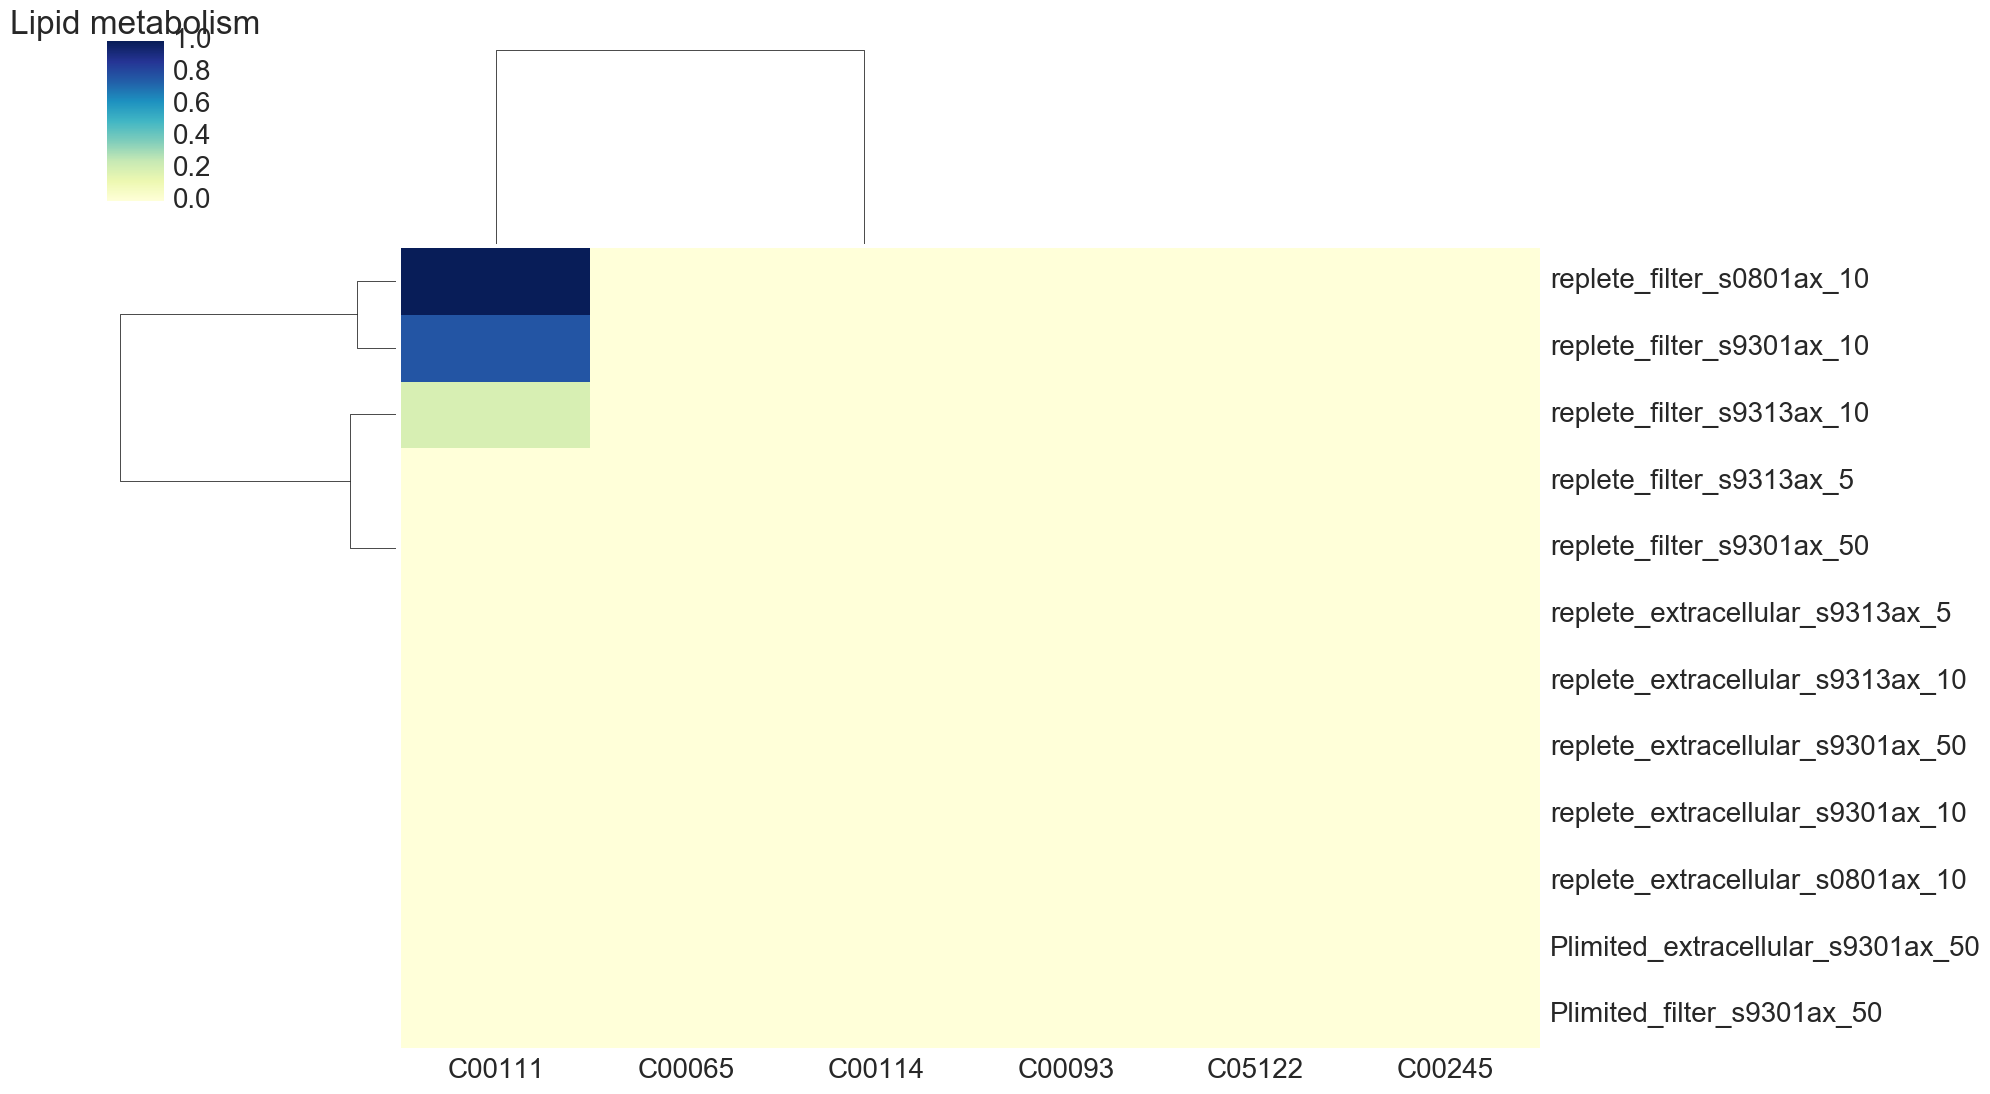

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00093	sn-Glycerol 3-phosphate; Glycerophosphoric acid; D-Glycerol 1-phosphate

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00114	Choline; Bilineurine

cpd:C00245	Taurine; 2-Aminoethanesulfonic acid; Aminoethylsulfonic acid

cpd:C05122	Taurocholate; Taurocholic acid; Cholyltaurine



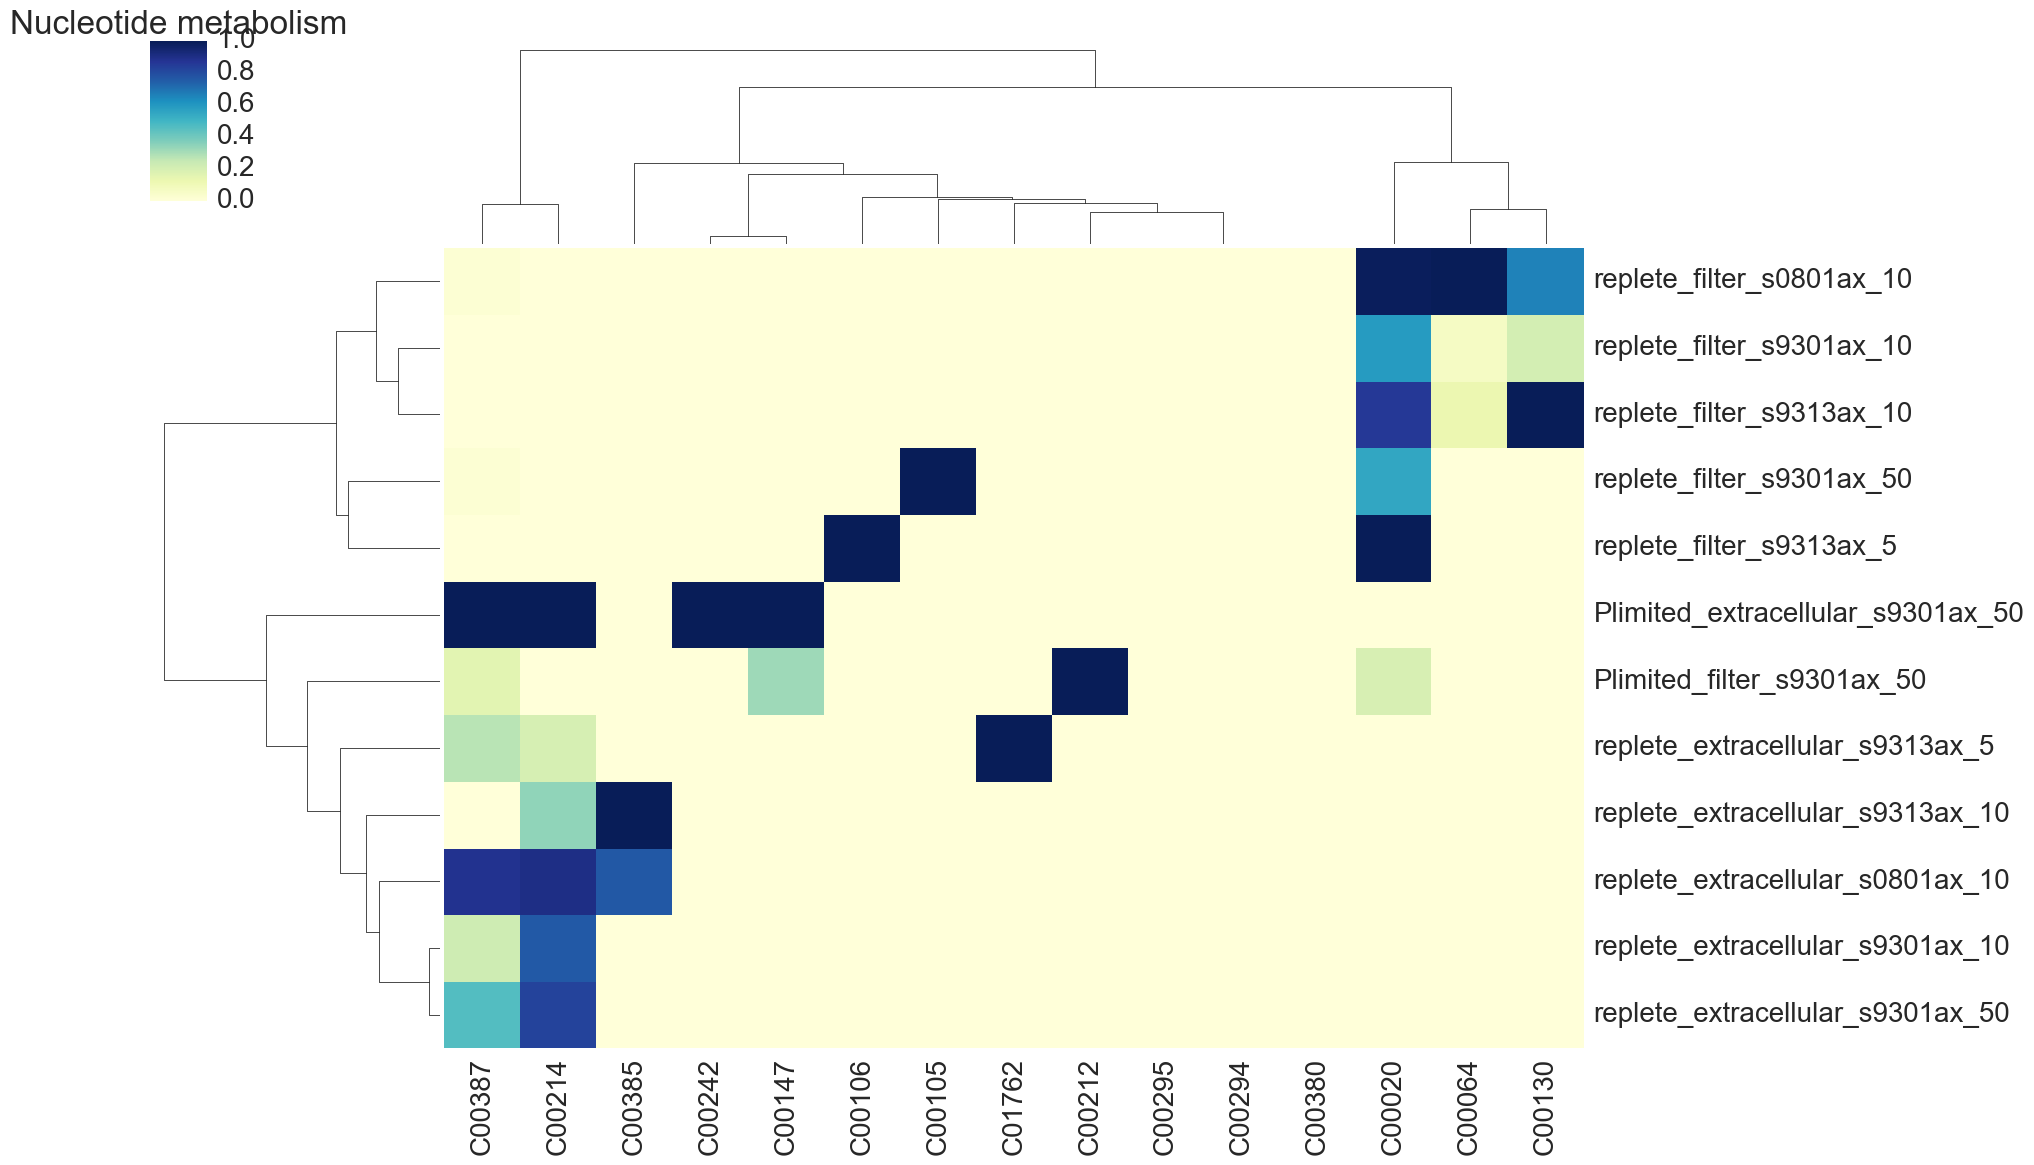

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00105	UMP; Uridylic acid; Uridine monophosphate; Uridine 5'-monophosphate; 5'Uridylic acid

cpd:C00106	Uracil

cpd:C00130	IMP; Inosinic acid; Inosine monophosphate; Inosine 5'-monophosphate; Inosine 5'-phosphate; 5'-Inosinate; 5'-Inosinic acid; 5'-Inosine monophosphate; 5'-IMP

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00212	Adenosine

cpd:C00214	Thymidine; Deoxythymidine

cpd:C00242	Guanine; 2-Amino-6-hydroxypurine

cpd:C00294	Inosine

cpd:C00295	Orotate; Orotic acid; Uracil-6-carboxylic acid

cpd:C00380	Cytosine

cpd:C00385	Xanthine

cpd:C00387	Guanosine

cpd:C01762	Xanthosine



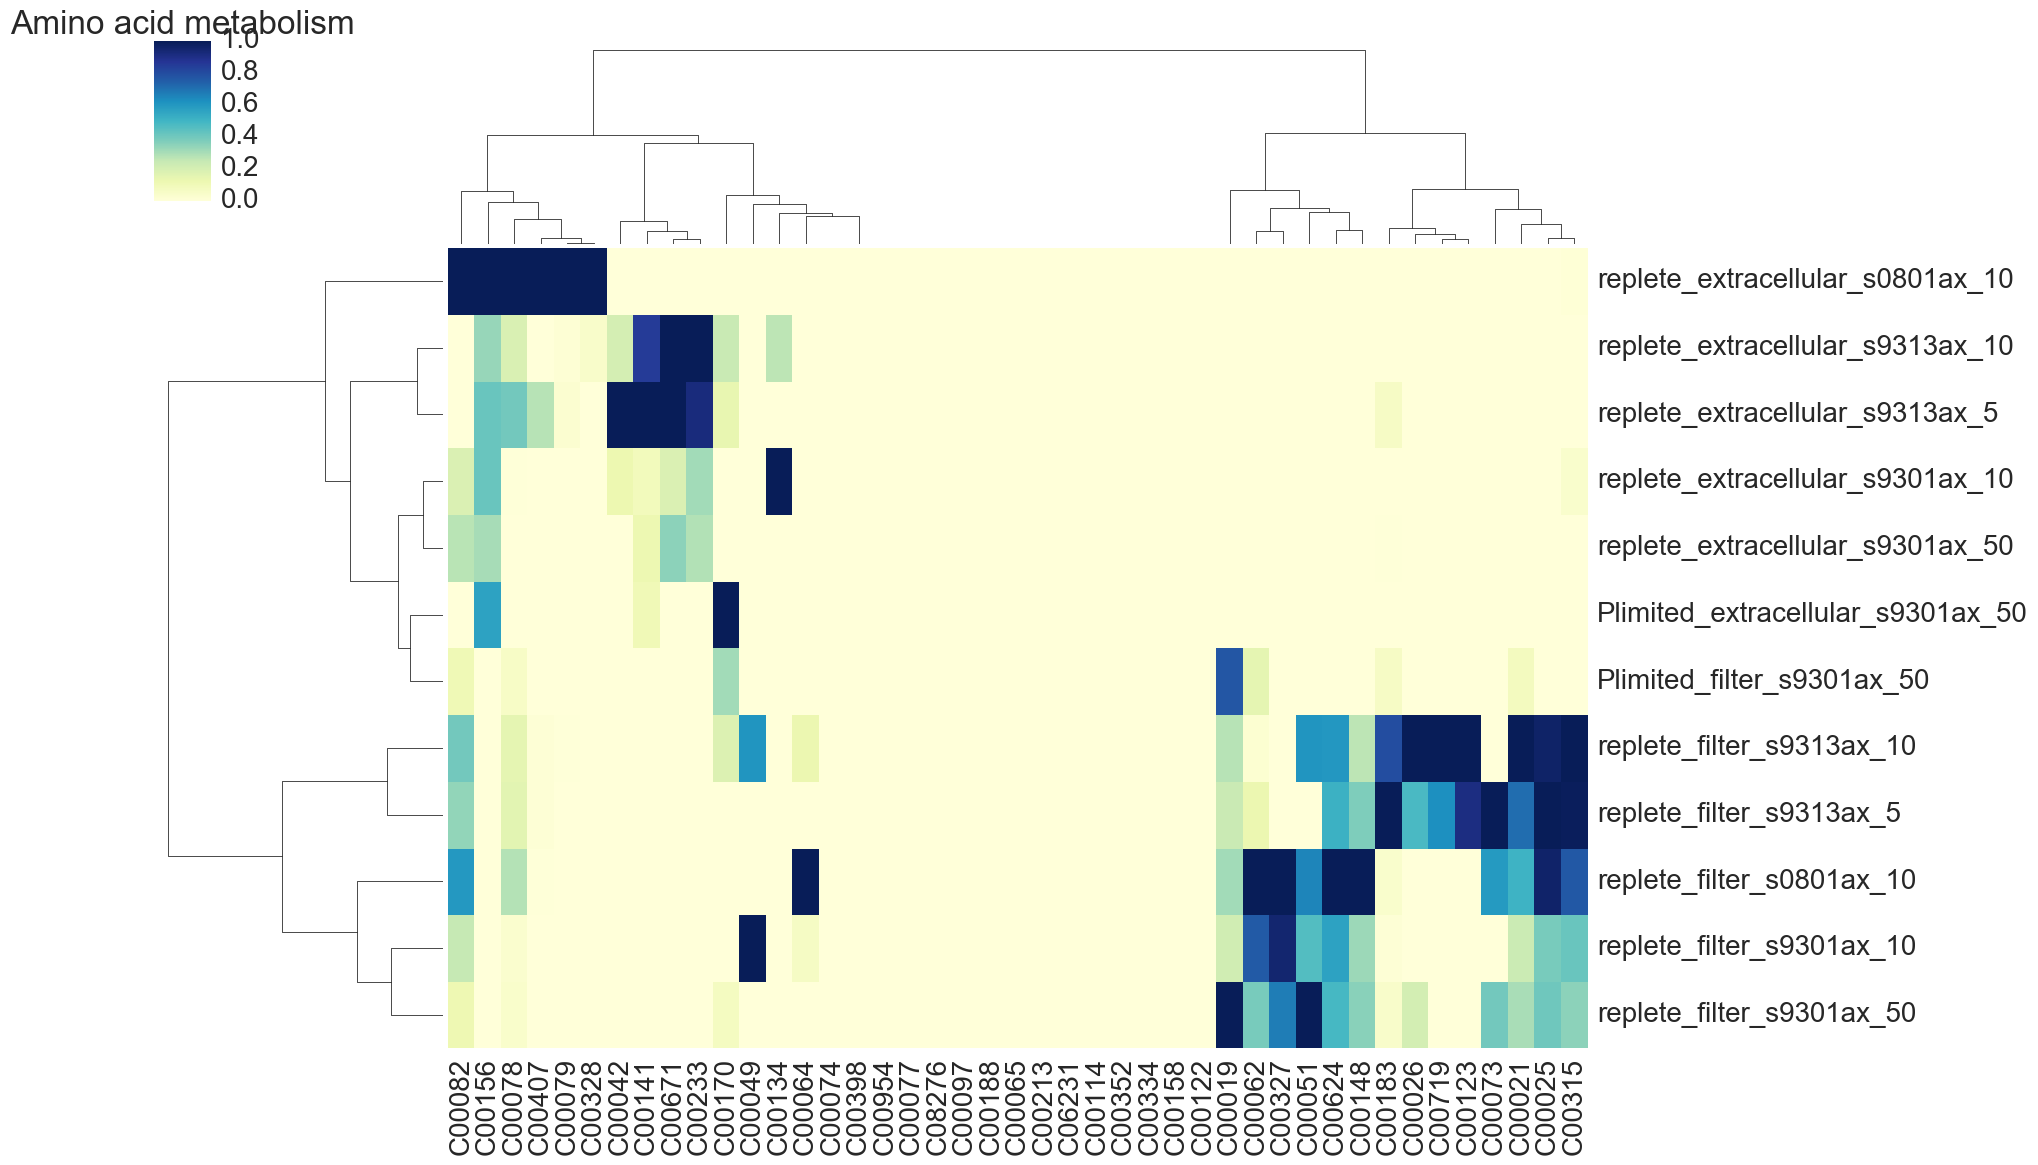

cpd:C00019	S-Adenosyl-L-methionine; S-Adenosylmethionine; AdoMet; SAM

cpd:C00021	S-Adenosyl-L-homocysteine; S-Adenosylhomocysteine

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00026	2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutaric acid; alpha-Ketoglutaric acid

cpd:C00042	Succinate; Succinic acid; Butanedionic acid; Ethylenesuccinic acid

cpd:C00049	L-Aspartate; L-Aspartic acid; 2-Aminosuccinic acid; L-Asp

cpd:C00051	Glutathione; 5-L-Glutamyl-L-cysteinylglycine; N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine; gamma-L-Glutamyl-L-cysteinyl-glycine; GSH; Reduced glutathione

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00073	L-Methionine; Methionine; L-2-Amino-4methylthiobutyric acid

cpd:C00074	Phosphoenolpyruvate; Phosphoenolpyruvic acid; PEP

cpd:C00077	L-Ornithine; (S)-2,5-Diaminovaleric acid; (S)

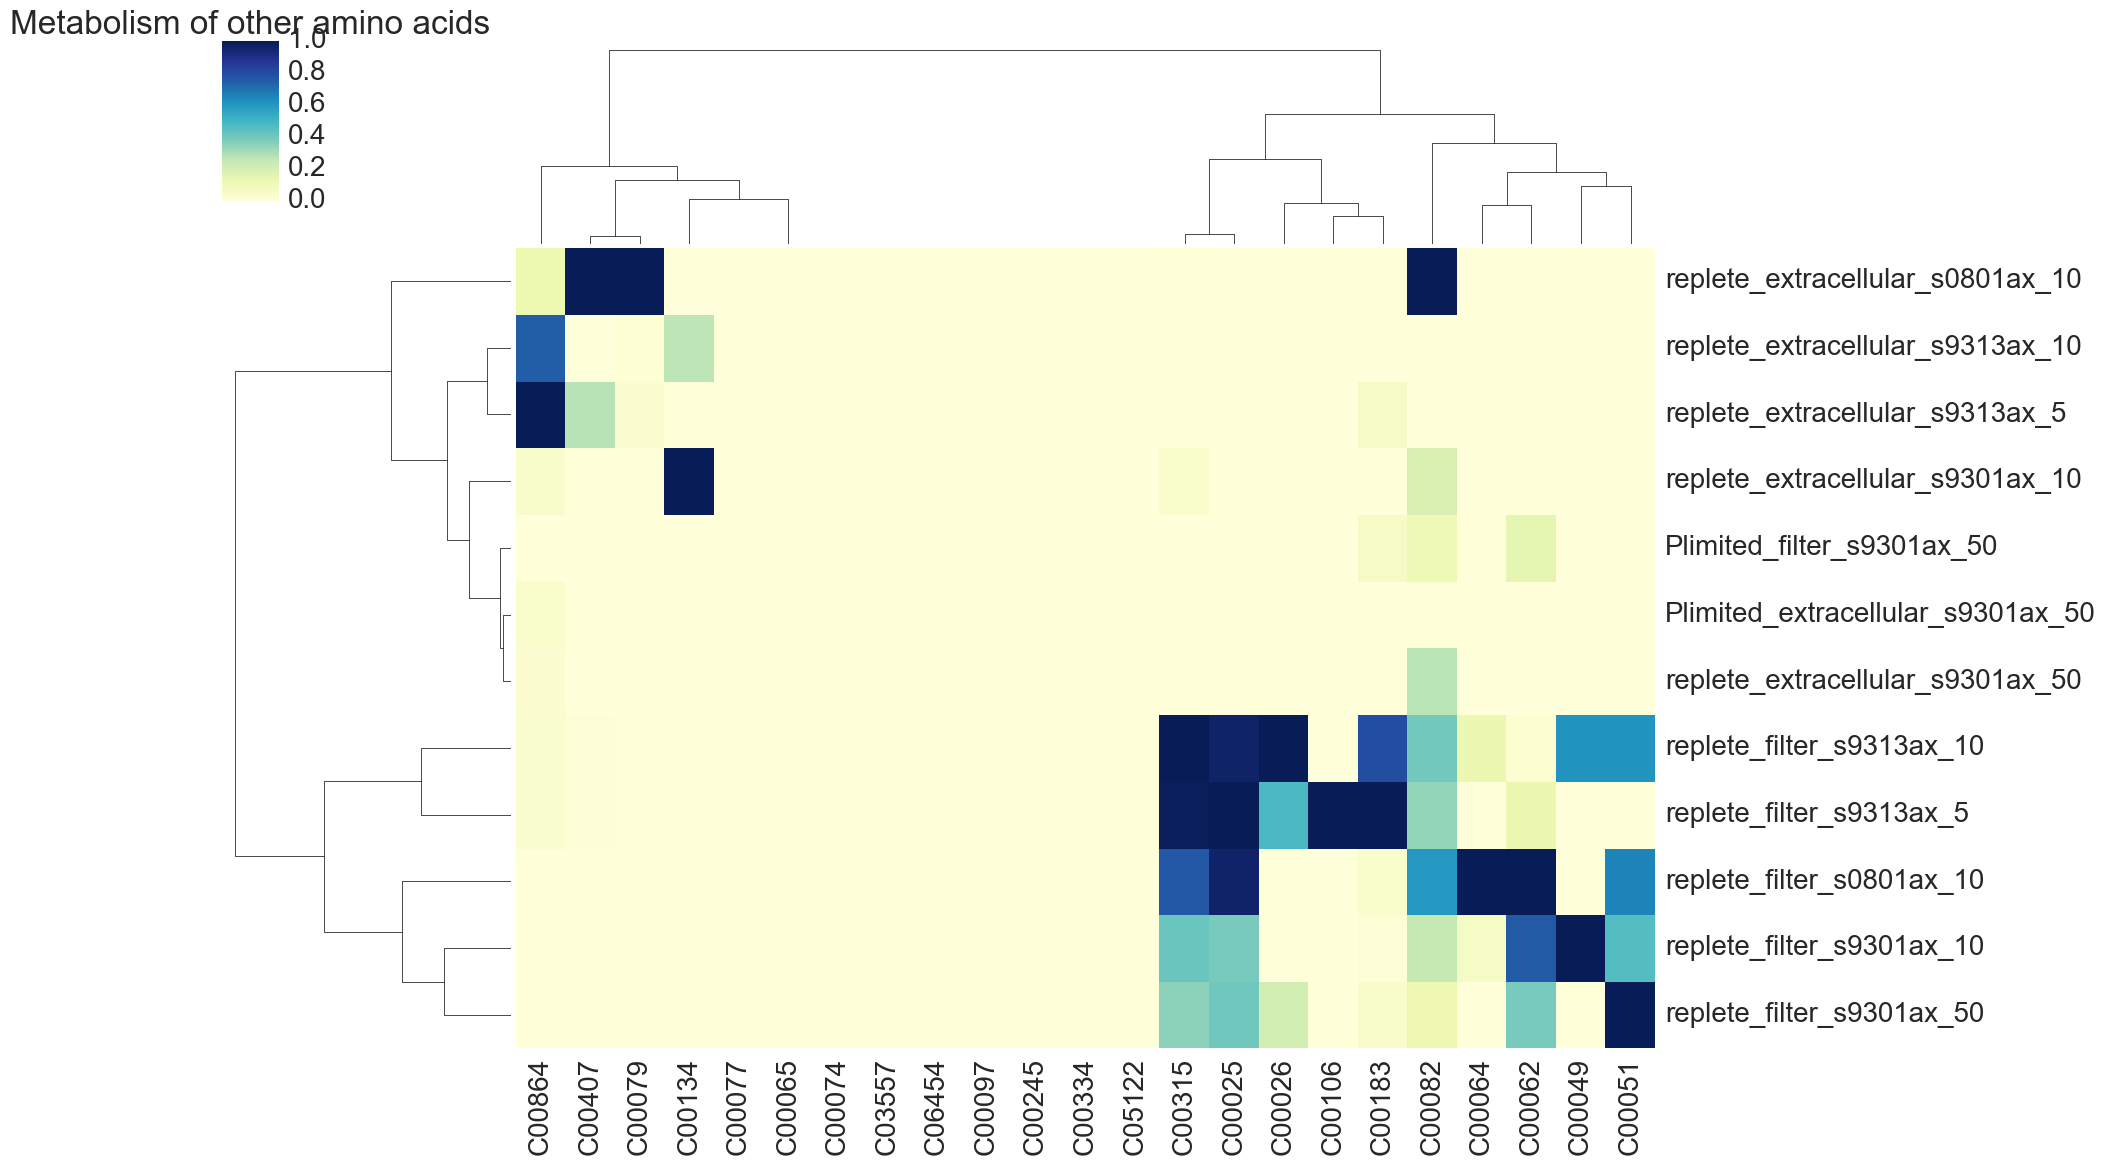

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00026	2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutaric acid; alpha-Ketoglutaric acid

cpd:C00049	L-Aspartate; L-Aspartic acid; 2-Aminosuccinic acid; L-Asp

cpd:C00051	Glutathione; 5-L-Glutamyl-L-cysteinylglycine; N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine; gamma-L-Glutamyl-L-cysteinyl-glycine; GSH; Reduced glutathione

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00074	Phosphoenolpyruvate; Phosphoenolpyruvic acid; PEP

cpd:C00077	L-Ornithine; (S)-2,5-Diaminovaleric acid; (S)-2,5-Diaminopentanoic acid; (S)-2,5-Diaminopentanoate

cpd:C00079	L-Phenylalanine; (S)-alpha-Amino-beta-phenylpropionic acid

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphenyl)alanine; (S)-2-Amino-3-(p-hydroxyphenyl)propionic acid; Tyrosine

cpd:C00097	L-Cysteine; L-2-Amino-3-mercaptopro

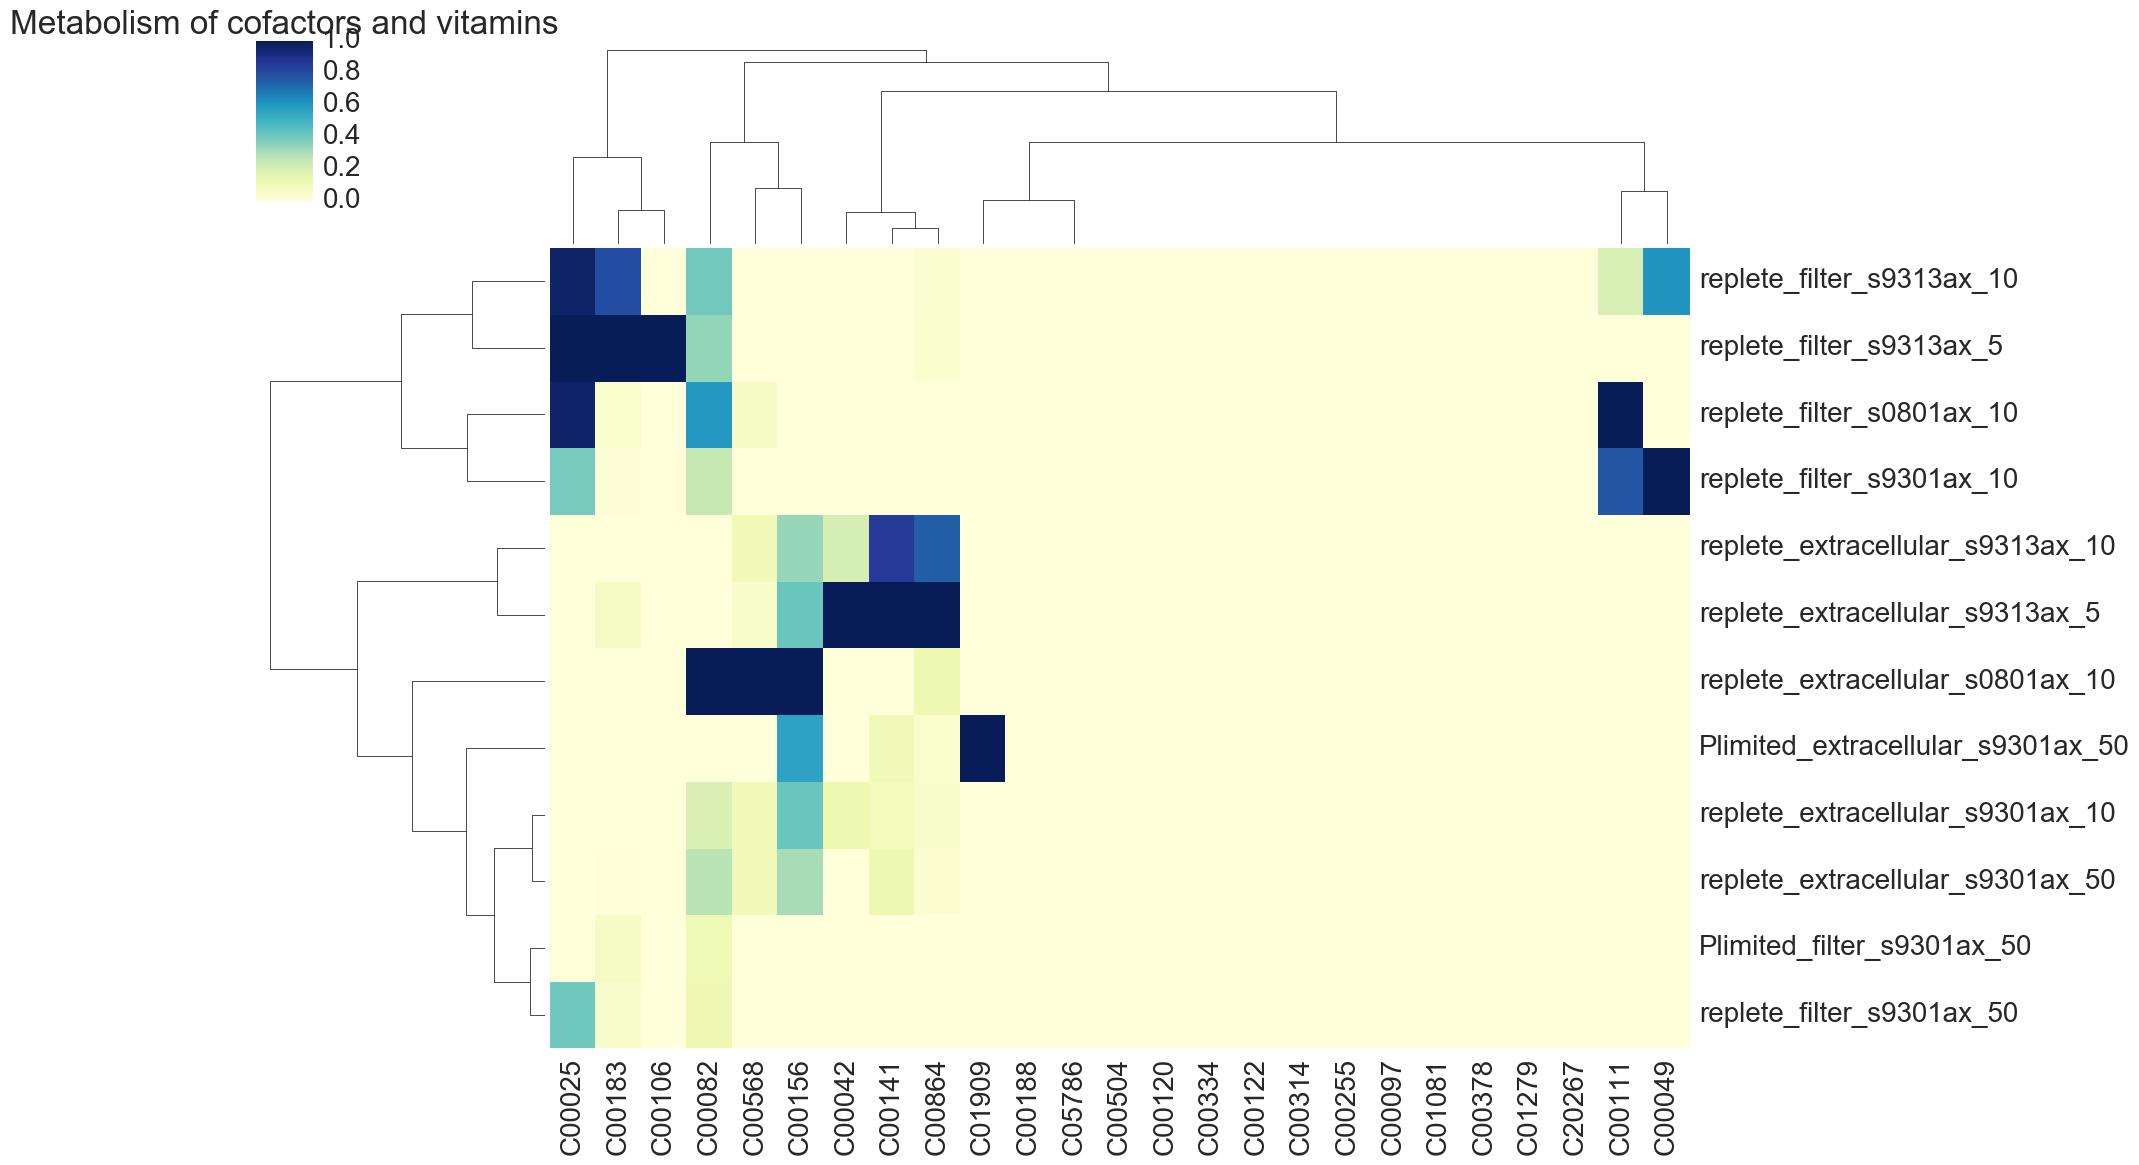

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00042	Succinate; Succinic acid; Butanedionic acid; Ethylenesuccinic acid

cpd:C00049	L-Aspartate; L-Aspartic acid; 2-Aminosuccinic acid; L-Asp

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphenyl)alanine; (S)-2-Amino-3-(p-hydroxyphenyl)propionic acid; Tyrosine

cpd:C00097	L-Cysteine; L-2-Amino-3-mercaptopropionic acid

cpd:C00106	Uracil

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00120	Biotin; D-Biotin; Vitamin H; Coenzyme R

cpd:C00122	Fumarate; Fumaric acid; trans-Butenedioic acid

cpd:C00141	3-Methyl-2-oxobutanoic acid; 3-Methyl-2-oxobutyric acid; 3-Methyl-2-oxobutanoate; 2-Oxo-3-methylbutanoate; 2-Oxoisovalerate; 2-Oxoisopentanoate; alpha-Ketovaline; 2-Ketovaline; 2-Keto-3-methylbutyric acid

cpd:C00156	4-Hydroxybenzoate; Hydroxybenzoic acid; 4-Hydroxybenzoic acid; Hydroxybenzenecarboxylic acid

cpd:C00183	L-Valine; 2-Amino-3-methylbutyric acid

cpd:C00188	L-

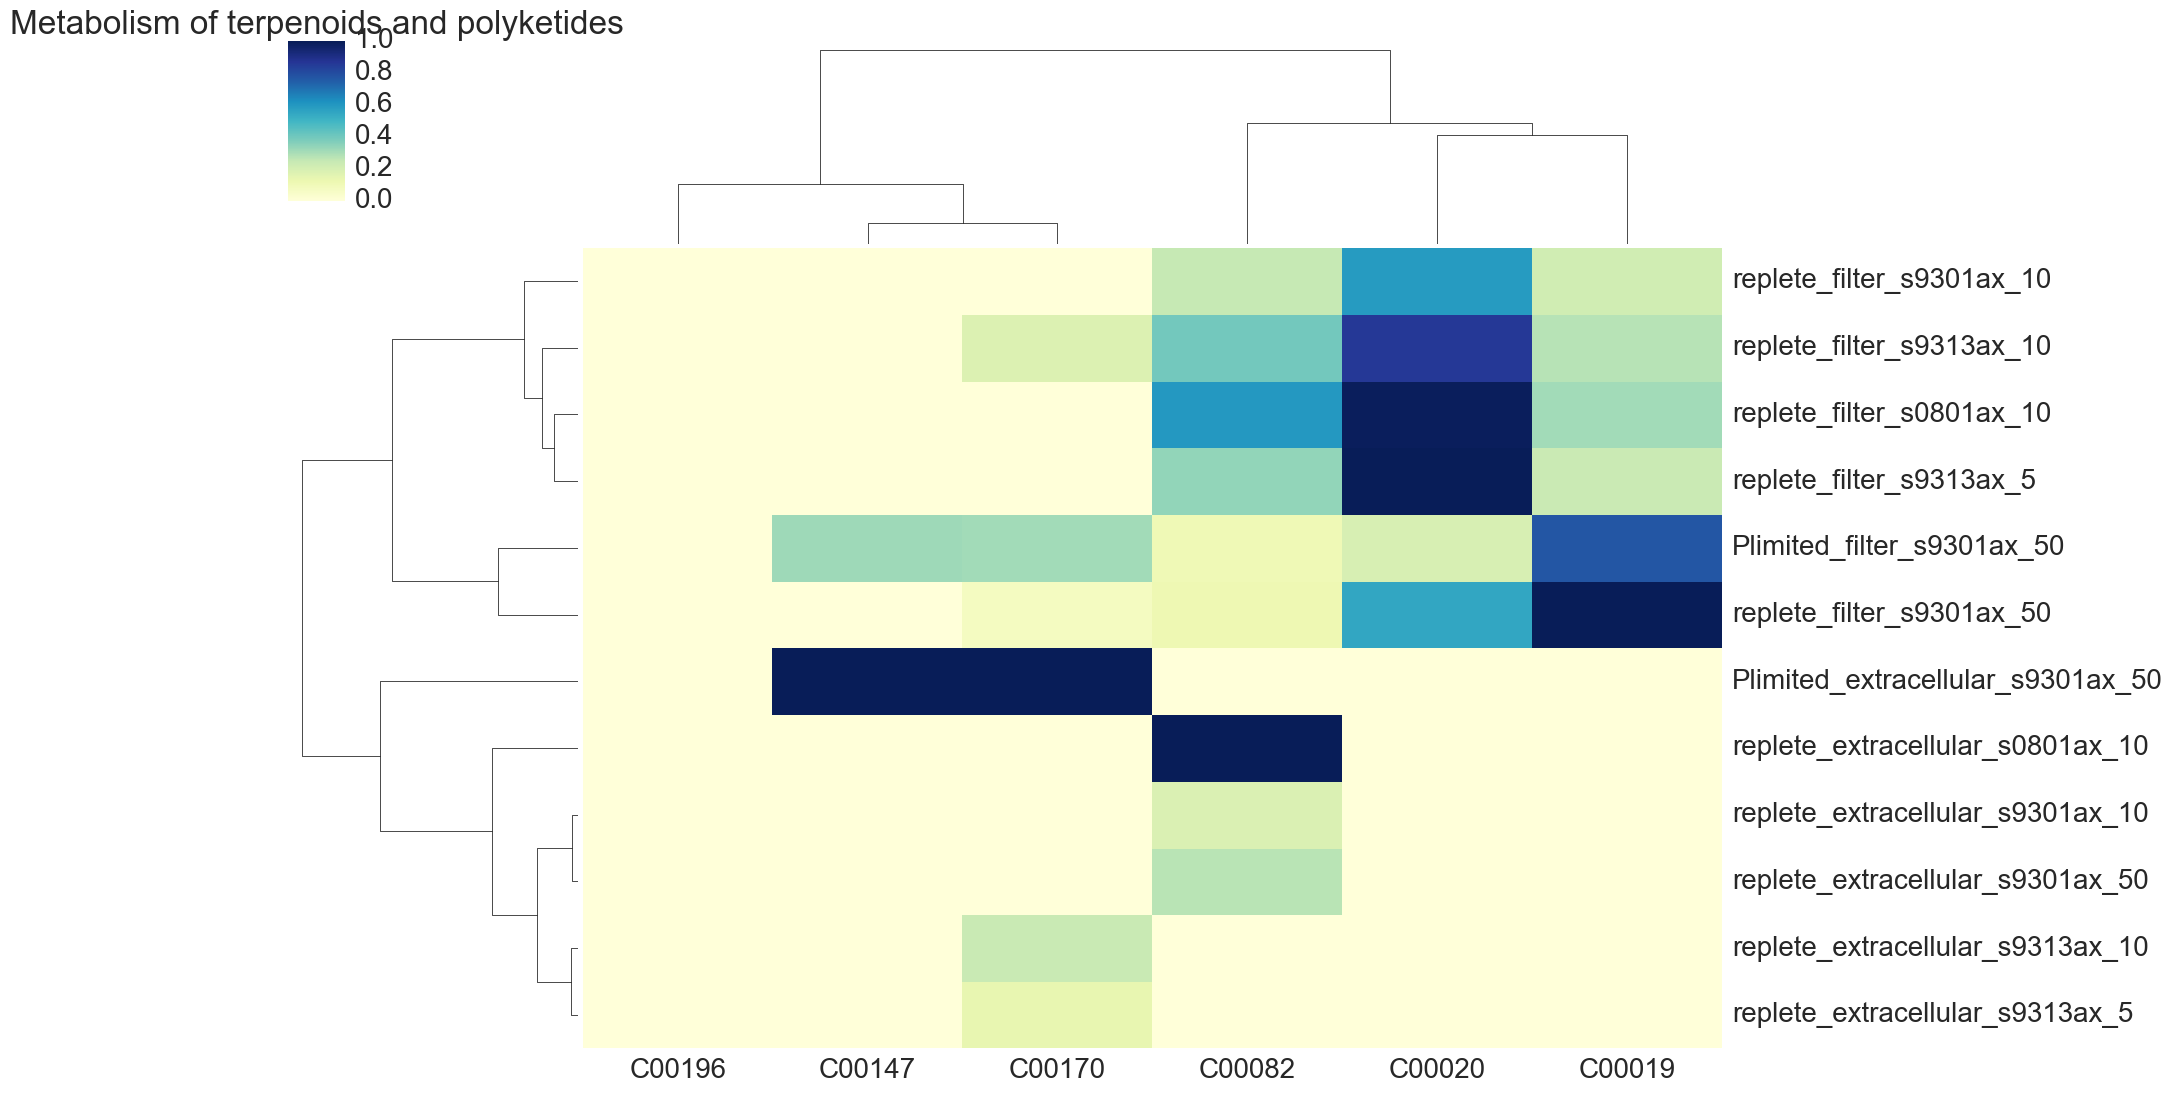

cpd:C00019	S-Adenosyl-L-methionine; S-Adenosylmethionine; AdoMet; SAM

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphenyl)alanine; (S)-2-Amino-3-(p-hydroxyphenyl)propionic acid; Tyrosine

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00170	5'-Methylthioadenosine; Methylthioadenosine; S-Methyl-5'-thioadenosine; 5-Methylthioadenosine; 5'-Deoxy-5'-(methylthio)adenosine; Thiomethyladenosine; MTA

cpd:C00196	2,3-Dihydroxybenzoate; 2,3-Dihydroxybenzoic acid



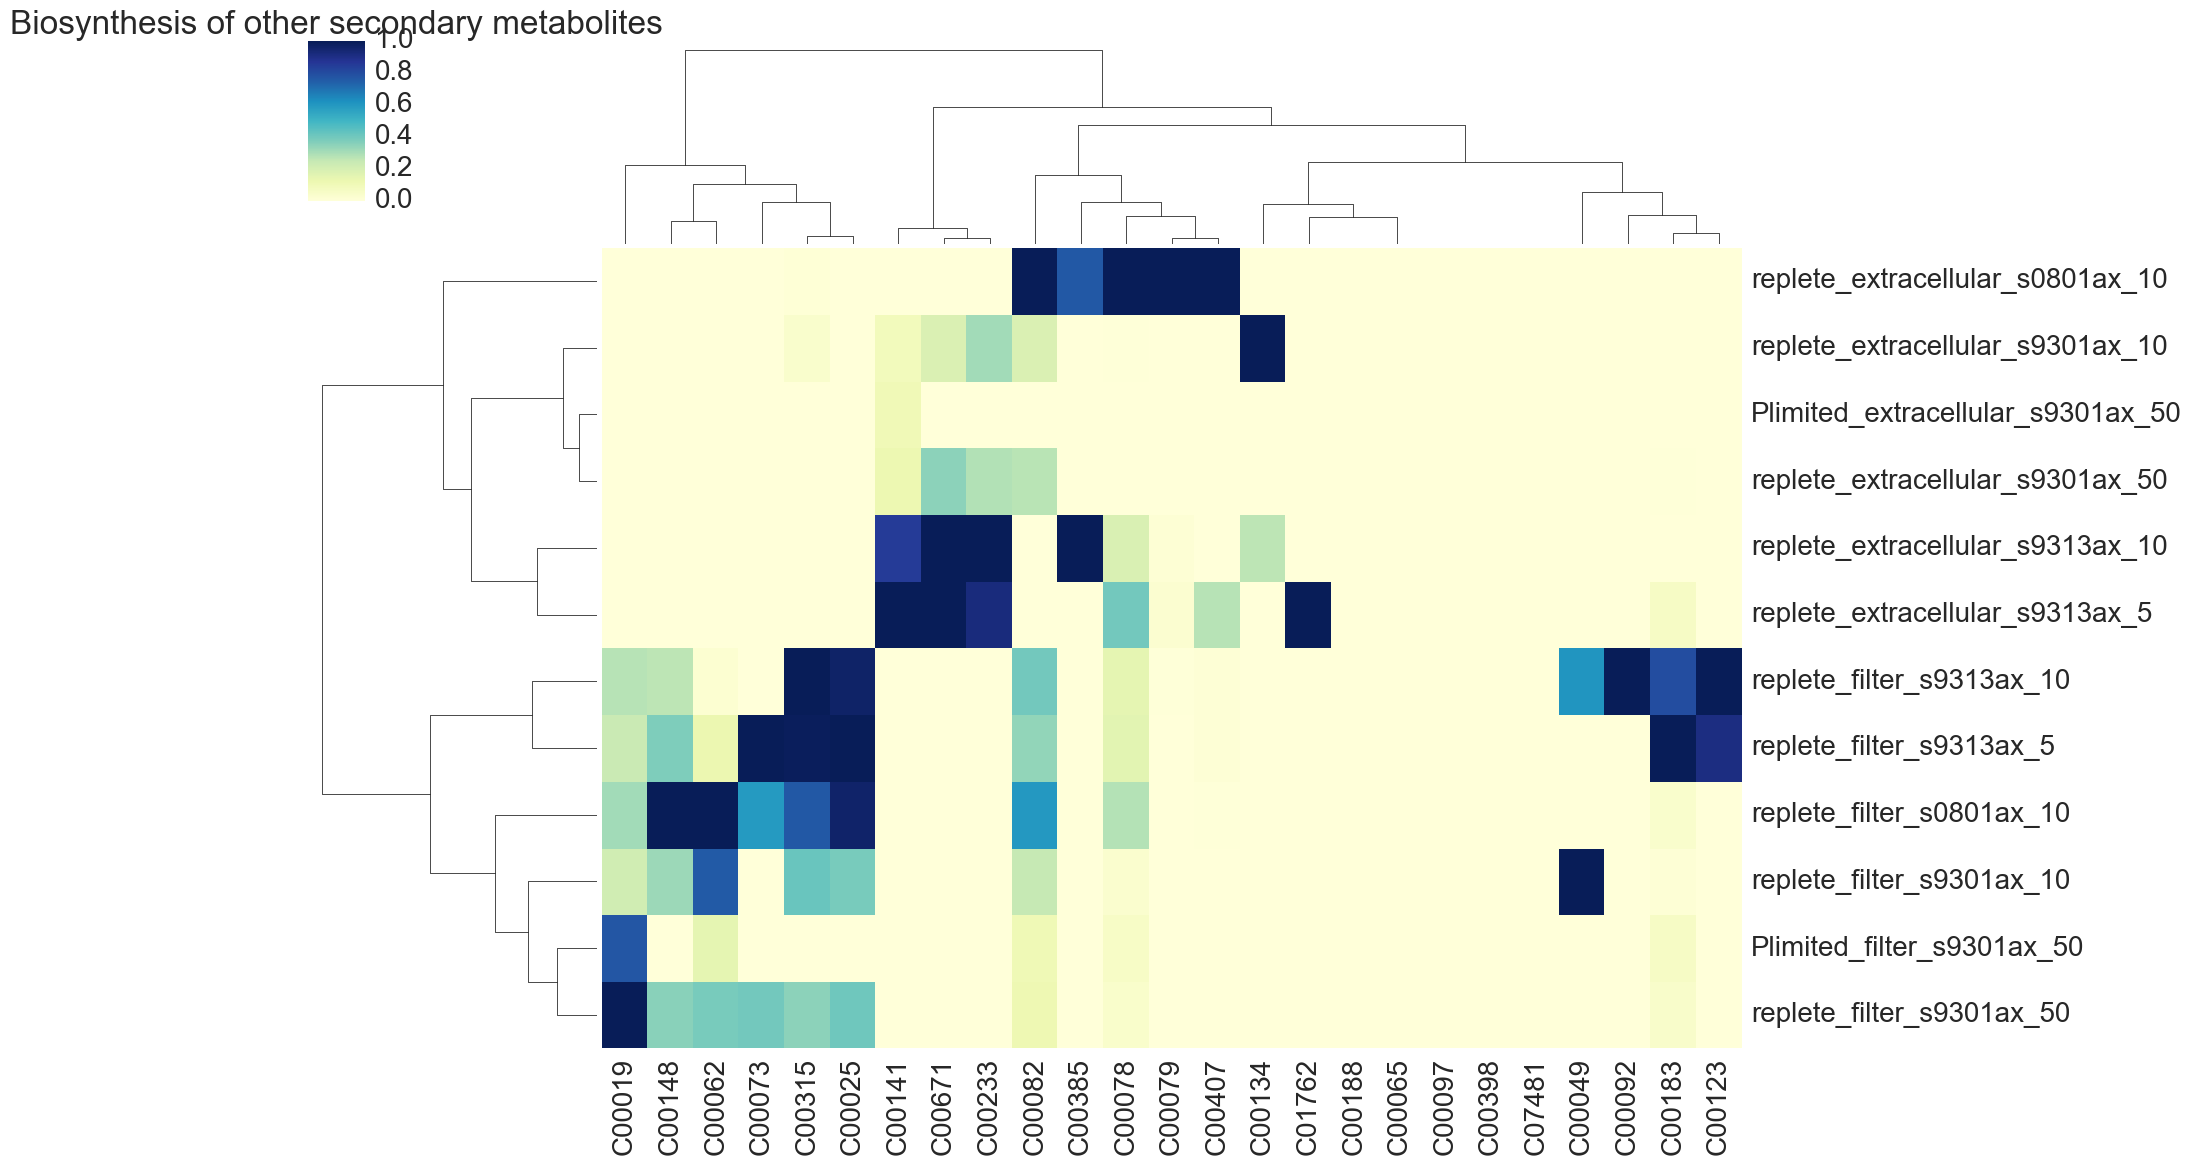

cpd:C00019	S-Adenosyl-L-methionine; S-Adenosylmethionine; AdoMet; SAM

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00049	L-Aspartate; L-Aspartic acid; 2-Aminosuccinic acid; L-Asp

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00065	L-Serine; L-2-Amino-3-hydroxypropionic acid; L-3-Hydroxy-alanine; Serine

cpd:C00073	L-Methionine; Methionine; L-2-Amino-4methylthiobutyric acid

cpd:C00078	L-Tryptophan; Tryptophan; (S)-alpha-Amino-beta-(3-indolyl)-propionic acid

cpd:C00079	L-Phenylalanine; (S)-alpha-Amino-beta-phenylpropionic acid

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphenyl)alanine; (S)-2-Amino-3-(p-hydroxyphenyl)propionic acid; Tyrosine

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00097	L-Cysteine; L-2-Amino-3-mercaptopropionic acid

cpd:C00123	L-Leucine; 2-Amino-4-methylvaleric acid; (2S)-alpha-2-Amino-4-methylvaleric acid; (2S)-alpha-Leucine

cpd:C00134	Putrescine; 1,4-Butanediamine; 1,4-Diamino

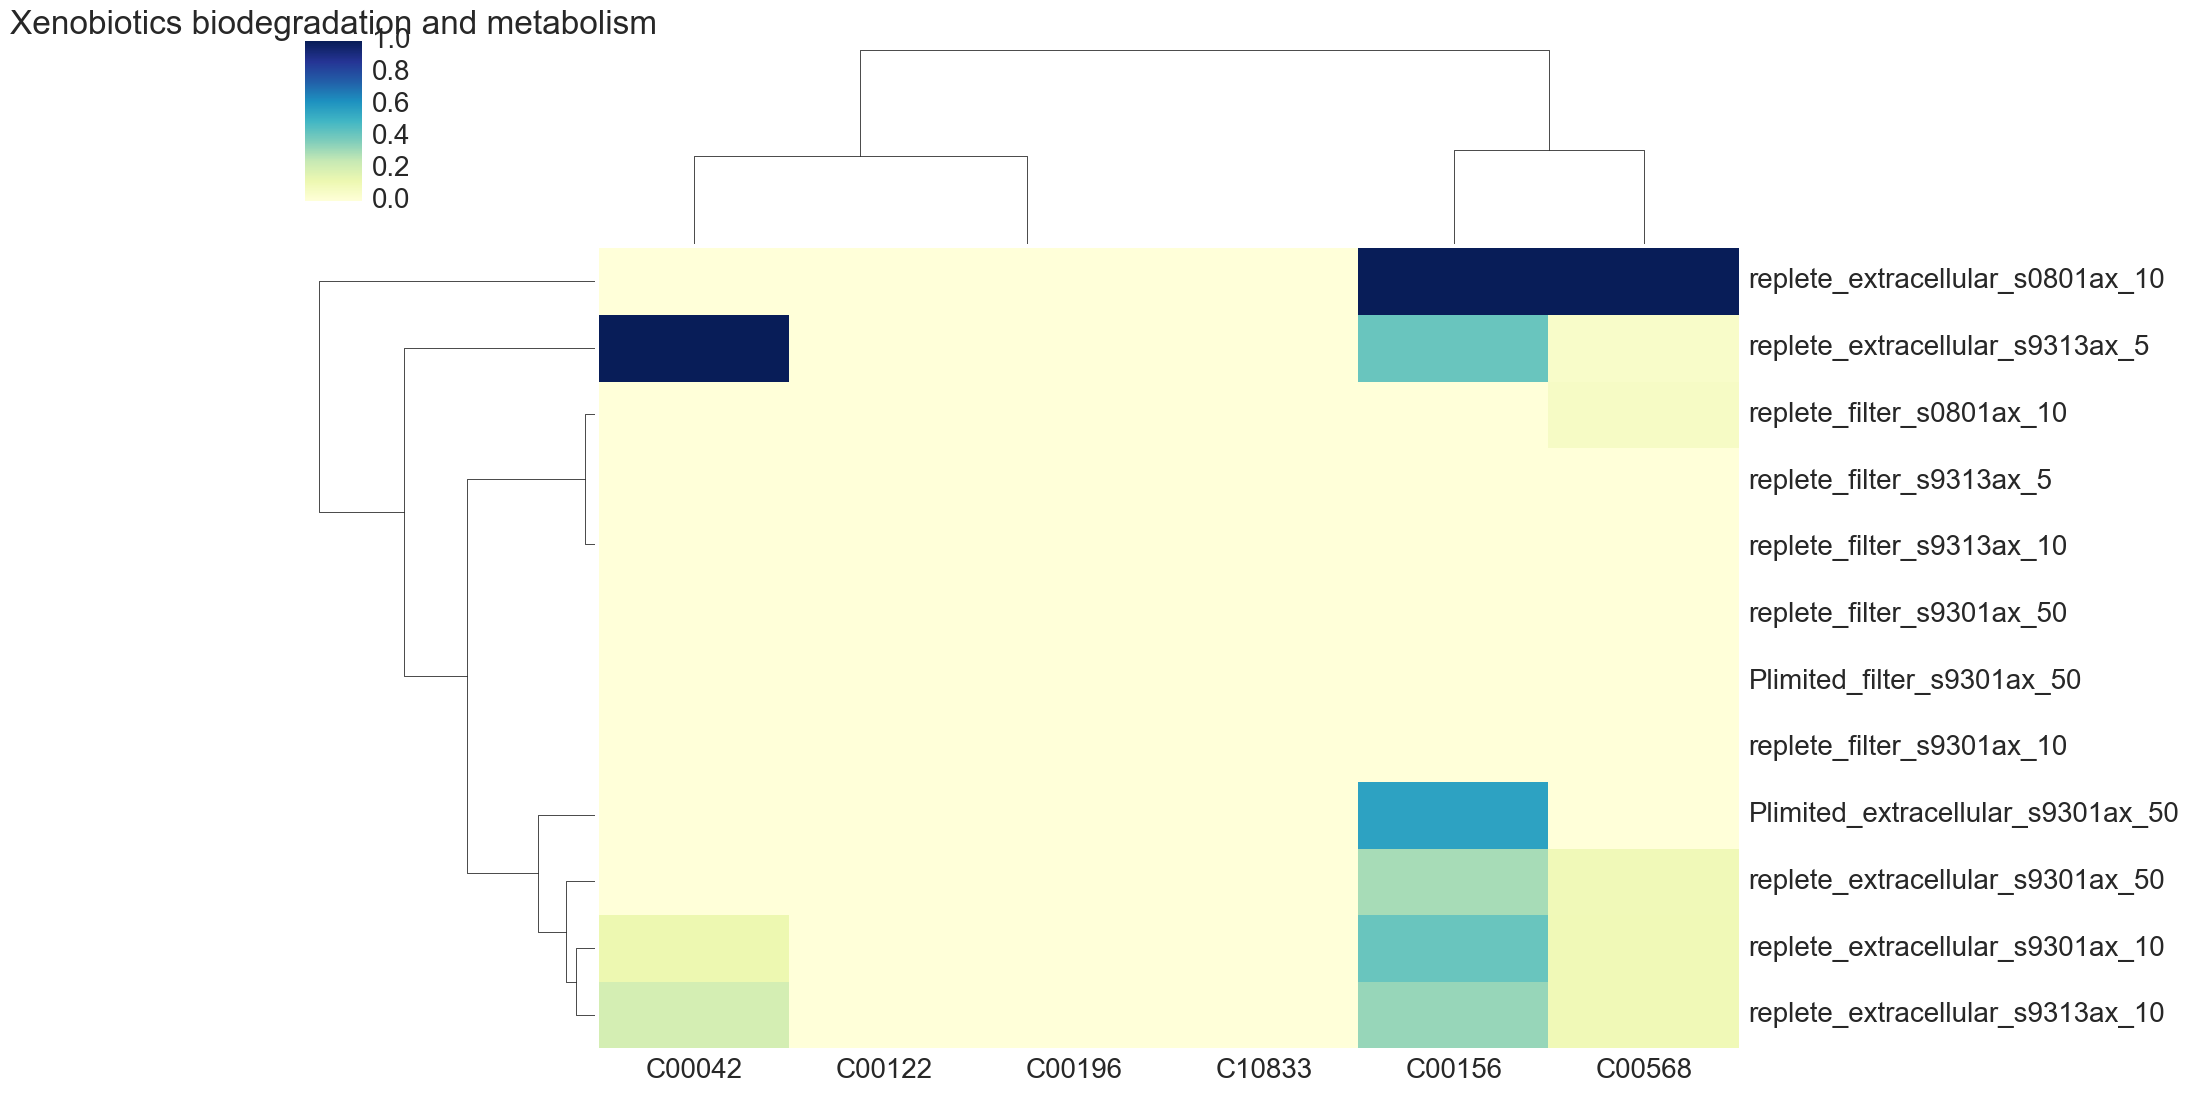

cpd:C00042	Succinate; Succinic acid; Butanedionic acid; Ethylenesuccinic acid

cpd:C00122	Fumarate; Fumaric acid; trans-Butenedioic acid

cpd:C00156	4-Hydroxybenzoate; Hydroxybenzoic acid; 4-Hydroxybenzoic acid; Hydroxybenzenecarboxylic acid

cpd:C00196	2,3-Dihydroxybenzoate; 2,3-Dihydroxybenzoic acid

cpd:C00568	4-Aminobenzoate; ABEE; 4-Aminobenzoic acid; p-Aminobenzoate

cpd:C10833	Syringic acid; Syringate; 4-Hydroxy-3,5-dimethoxybenzoate; Gallic acid 3,5-dimethyl ether

Chemical structure transformation maps: has no metabolites


In [55]:
#plot the data for each type of metabolism map (all strains)
useCO = mtabPruned.index
for oneGroup in unMetabolismGroups:
    #next line will make the color maps for each group: purple = low; green = high
    #these are scaled data, from 01 to 1 
    scaled = True
    plotByGroup.plotGroup_clusterT(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain,scaled)

Use the information at KEGG to find the theoretical overlap across the strains
----

In [56]:
#use biopython/KEGG module to get the information
pmgPathways = kegg_list('pathway','pmg').read()
pmgTrim = trimPath(pmgPathways)

prmPathways = kegg_list('pathway','prm').read()
prmTrim = trimPath(prmPathways)

pmtPathways = kegg_list('pathway','pmt').read()
pmtTrim = trimPath(pmtPathways)

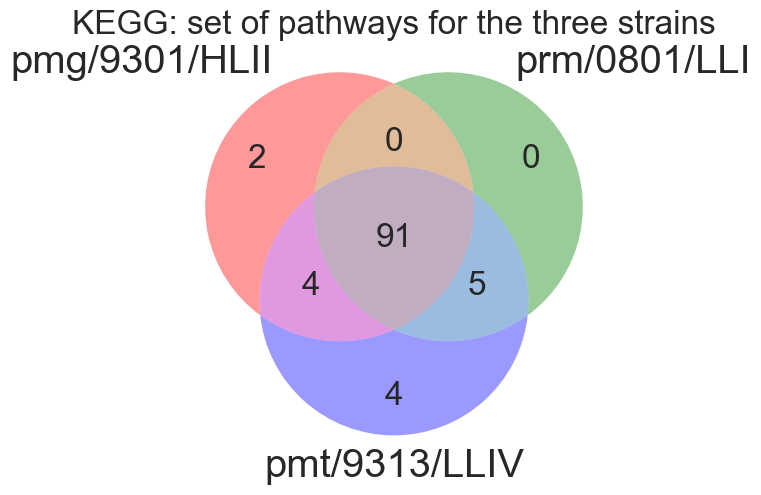

In [57]:
venn3_unweighted(subsets = (set(pmgTrim),set(prmTrim),set(pmtTrim)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of pathways for the three strains')
plt.savefig('Pro_pathways.png')

In [58]:
#pull the full set of compounds for each strain...
#have to loop through the genes because the KEGG / REST code will not do this 
#pull the full set of genes for each strain...
pmtGenes = trimGenes(kegg_link("ko","pmt").read())
pmgGenes = trimGenes(kegg_link("ko","pmg").read())
prmGenes = trimGenes(kegg_link("ko","prm").read())

In [59]:
#setup the strings to match first
rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190

pmg_countCpd = []
pmg_countGene = []
pmg_countRxn = []
        
for gen in pmgGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmg_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmg_countCpd.append(m2) 
                    pmg_countGene.append(gen)

In [60]:
pmt_countCpd = []
pmt_countGene = []
pmt_countRxn = []

for gen in pmtGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            pmt_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    pmt_countCpd.append(m2) 
                    pmt_countGene.append(gen)

In [61]:
prm_countCpd = []
prm_countGene = []
prm_countRxn = []

for gen in prmGenes: #go through each gene...one at a time
    rnList = kegg_link('reaction',gen).read() #get the list of reactions for that gene
    #can have cases where there is a gene and no reaction (K02906 for example). This returns rnList = '\n'
    #since this is not actually empty...need a few way to filter those out
    test = '\n'
    if test != rnList:
        for line in rnList.rstrip().split('\n'):
            m = rnString.search(line) #get the reaction number
            prm_countRxn.append(m.group(0))
            cpdList = kegg_link('cpd',m.group(0)).read() #now go get the compounds for that reaction
            del m #have to do this so I can pickle the whole thing later...
            #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
            if len(cpdList) > 1: #will be true if cpdList includes compounds
                for line2 in cpdList.rstrip().split('\n'):
                    m2 = cpdString.search(line2).group(0)
                    prm_countCpd.append(m2) 
                    prm_countGene.append(gen)

Consider the overlap in compounds among the three strains
---

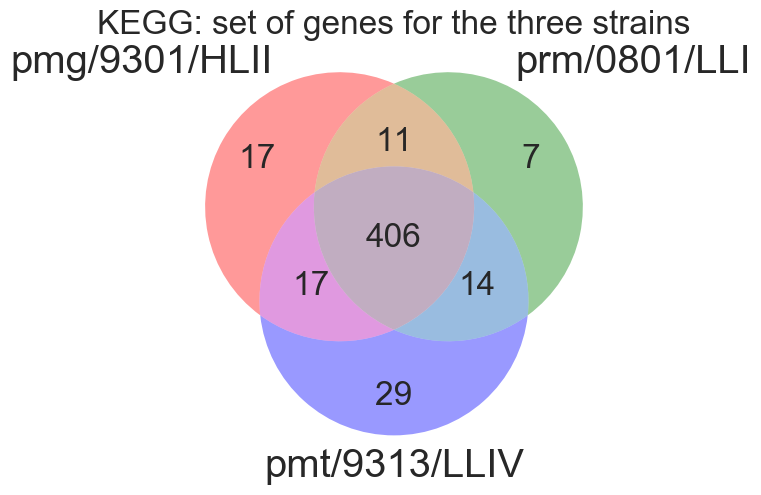

In [62]:
v = venn3_unweighted(subsets = (set(pmg_countGene),set(prm_countGene),set(pmt_countGene)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of genes for the three strains')
#plt.savefig('Pro_genes.png')

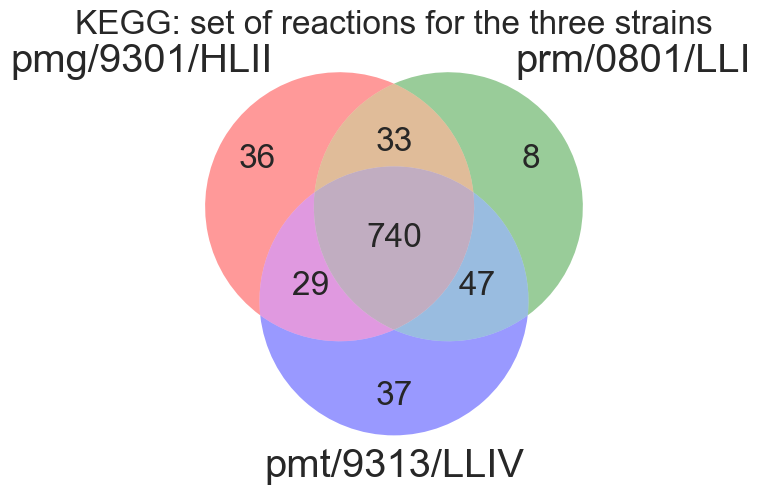

In [63]:
v = venn3_unweighted(subsets = (set(pmg_countRxn),set(prm_countRxn),set(pmt_countRxn)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of reactions for the three strains')
#plt.show() #don't do this...this creates a new figure
#plt.savefig('Pro_reactions.png')

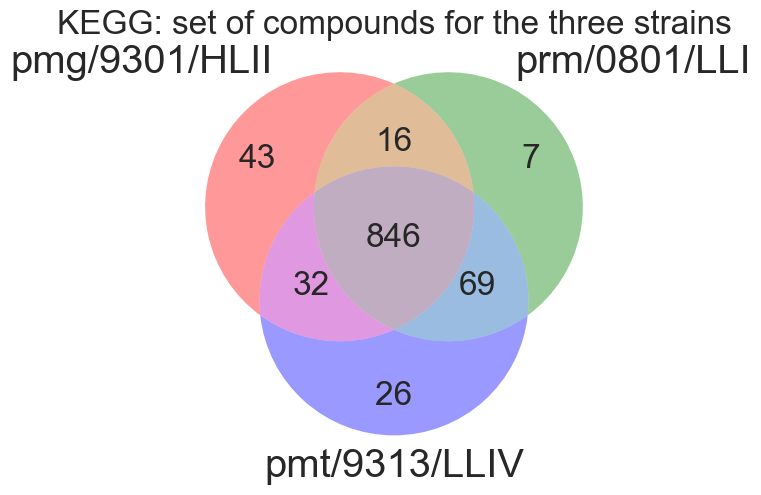

In [64]:
venn3_unweighted(subsets = (set(pmg_countCpd),set(prm_countCpd),set(pmt_countCpd)),set_labels = 
                 ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('KEGG: set of compounds for the three strains')
plt.savefig('Pro_cpds.png')

In [65]:
#what are the differences?
rxnString = set(prm_countRxn) - (set(pmg_countRxn)| set(pmt_countRxn))
#rxnString = set(pmg_countRxn) - (set(prm_countRxn)| set(pmt_countRxn))
#rxnString = set(pmt_countRxn) - (set(prm_countRxn)| set(pmg_countRxn))
#set(pmg_countGene) & set(prm_countGene)- set(pmt_countGene)
rxnString.pop()

'R00196'

In [66]:
kegg_get('R00956').read() #get information about a reaction

'ENTRY       R00956                      Reaction\nNAME        CTP:alpha-D-glucose-1-phosphate cytidylyltransferase\nDEFINITION  CTP + D-Glucose 1-phosphate <=> Diphosphate + CDP-glucose\nEQUATION    C00063 + C00103 <=> C00013 + C00501\nRCLASS      RC00002  C00103_C00501\nENZYME      2.7.7.33\nPATHWAY     rn00500  Starch and sucrose metabolism\n            rn00520  Amino sugar and nucleotide sugar metabolism\n            rn01100  Metabolic pathways\nORTHOLOGY   K00978  glucose-1-phosphate cytidylyltransferase [EC:2.7.7.33]\nDBLINKS     RHEA: 18216\n///\n'

In [67]:
# cpdString = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd) #in all three.
cpdString = set(prm_countCpd) - (set(pmg_countCpd)| set(pmt_countCpd))
for item in cpdString:
    print(kegg_list(item).read())

cpd:C00501	CDP-glucose; CDP-D-Glucose

cpd:C20762	3-O-Phospho-alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C01219	CDP-4-dehydro-6-deoxy-D-glucose

cpd:C20761	alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol

cpd:C00186	(S)-Lactate; L-Lactate; L-Lactic acid

cpd:C01417	Cyanate; Cyanic acid

cpd:C20763	3-O-Methylphospho-alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-[alpha-D-Man-(1->2)-alpha-D-Man-(1->2)-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)]n-alpha-D-Man-(1->3)-alpha-D-Man-(1->3)-alpha-D-GlcNAc-diphospho-ditrans,octacis-undecaprenol



In [68]:
#remember - this is the theoretical overlap based on KEGG
all3 = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        #print(kegg_list(item).read())

In [69]:
#is a cpd in all three strains? or some lower number? ...only filter data here
cpd_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('filter_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            cpd_inNstrains.loc[oneCpd,st] = 1
    
    a = cpd_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        cpd_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        cpd_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        cpd_inNstrains.loc[oneCpd,'in1'] = 1
    else: #will never have a=0 bc the if not r.empty statement
        cpd_inNstrains.loc[oneCpd,'in0'] = 1
        
sumCount = cpd_inNstrains.sum(axis=0)

In [70]:
r = cpd_inNstrains[cpd_inNstrains.loc[:,'in3'].gt(0)] #in 3...perhaps 'core' mtabs in Pro
for item in r.index:
    print(kegg_list(item).read())

cpd:C00671	(S)-3-Methyl-2-oxopentanoic acid; (S)-3-Methyl-2-oxopentanoate; (3S)-3-Methyl-2-oxopentanoic acid; (3S)-3-Methyl-2-oxopentanoate

cpd:C00233	4-Methyl-2-oxopentanoate; 2-Oxoisocaproate

cpd:C00020	AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate

cpd:C00062	L-Arginine; (S)-2-Amino-5-guanidinovaleric acid; L-Arg

cpd:C00111	Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate

cpd:C00025	L-Glutamate; L-Glutamic acid; L-Glutaminic acid; Glutamate

cpd:C00064	L-Glutamine; L-2-Aminoglutaramic acid

cpd:C00130	IMP; Inosinic acid; Inosine monophosphate; Inosine 5'-monophosphate; Inosine 5'-phosphate; 5'-Inosinate; 5'-Inosinic acid; 5'-Inosine monophosphate; 5'-IMP

cpd:C00051	Glutathione; 5-L-Glutamyl-L-cysteinylglycine; N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine; gamma-L-Glutamyl-L-cysteinyl-glycine; GSH; Reduced glutathione

cpd:C00082	L-Tyrosine; (S)-3-(p-Hydroxyphen

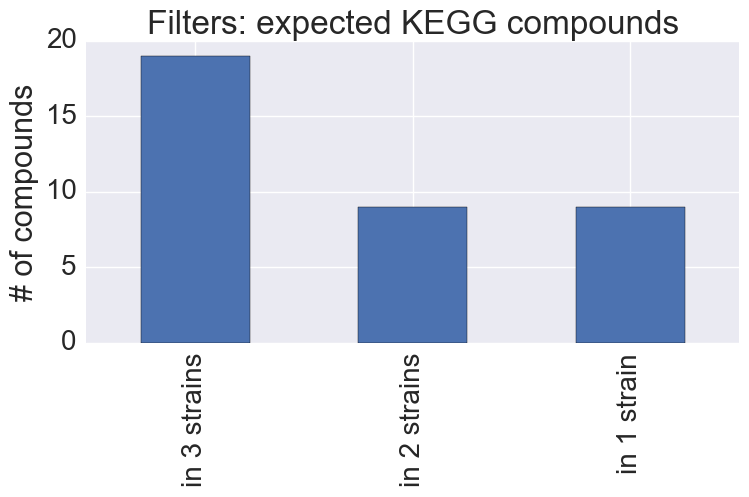

In [71]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('Filters: expected KEGG compounds')
axs.set_ylabel('# of compounds')
tLabel = ['in 3 strains','in 2 strains','in 1 strain']
axs.set_xticklabels(tLabel)
plt.tight_layout()
plt.savefig('nCompounds_filters.jpg')

Did we see what we expected based on the strain differences?
---

In [72]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

In [73]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00719	Betaine; Trimethylaminoacetate; Glycine betaine; N,N,N-Trimethylglycine; Trimethylammonioacetate

cpd:C06767	Hemine; Hemin



In [74]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C06767	Hemine; Hemin

cpd:C00315	Spermidine; N-(3-Aminopropyl)-1,4-butane-diamine



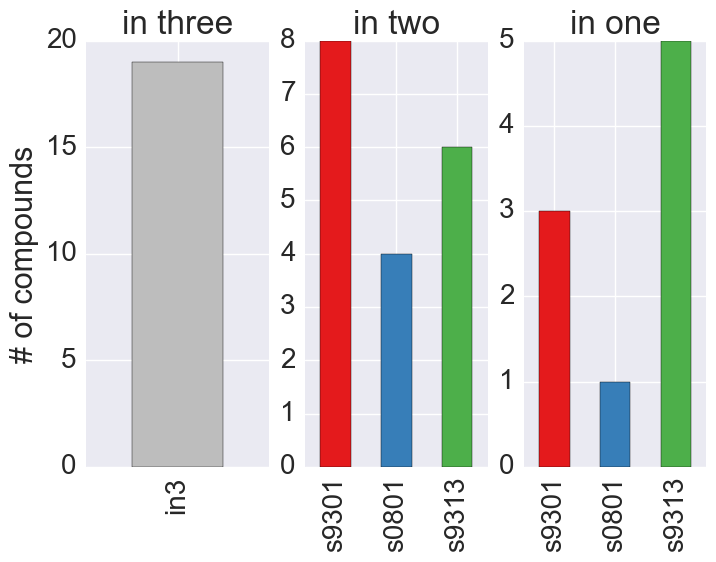

In [75]:
#count up the subsets for plotting (messy)
fi = cpd_inNstrains[cpd_inNstrains.loc[:,'in2']==1]
countSub = fi.sum(axis=0)

fi1 = cpd_inNstrains[cpd_inNstrains.loc[:,'in1']==1]
countSub1 = fi1.sum(axis=0)

pStrains = ['s9301','s0801','s9313']
useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors
fig,axs = plt.subplots(1,3)
sumCount.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')

countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3_filters.jpg')

In [76]:
gI = fi1.index

for item in gI:
    if fi1.loc[item,'s9301']==1:
        print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C00212	Adenosine

cpd:C00105	UMP; Uridylic acid; Uridine monophosphate; Uridine 5'-monophosphate; 5'Uridylic acid



In [77]:
for item in gI:
    if fi1.loc[item,'s0801']==1:
        print(kegg_list(item).read())

cpd:C00568	4-Aminobenzoate; ABEE; 4-Aminobenzoic acid; p-Aminobenzoate



In [78]:
for item in gI:
    if fi1.loc[item,'s9313']==1:
        print(kegg_list(item).read())

cpd:C01674	Chitobiose; Diacetylchitobiose; N,N'-Diacetylchitobiose

cpd:C00092	D-Glucose 6-phosphate; Glucose 6-phosphate; Robison ester

cpd:C00123	L-Leucine; 2-Amino-4-methylvaleric acid; (2S)-alpha-2-Amino-4-methylvaleric acid; (2S)-alpha-Leucine

cpd:C00864	Pantothenate; Pantothenic acid; (R)-Pantothenate

cpd:C00106	Uracil



In [79]:
#go find all possible pathways for that compound

In [80]:
oneCpd='C01674'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00520	Amino sugar and nucleotide sugar metabolism

path:map01100	Metabolic pathways

path:map02010	ABC transporters

path:map02060	Phosphotransferase system (PTS)



Try extracellur, assume that if in genes, Pro will release it
---

In [81]:
#is a cpd in all three strains? or some lower number? ...extracellular
released_inNstrains = pd.DataFrame(index = useCO,columns = ['in3','in2','in1','in0','s9301','s0801','s9313'])

for oneCpd in useCO:
    strains = {'s9301','s0801','s9313'}
    for st in strains:
        df2 = mtabPruned.loc[oneCpd].filter(regex = ('extracellular_' + st))
        r = df2[df2.gt(0)]
        if not r.empty:
            released_inNstrains.loc[oneCpd,st] = 1
    
    a = released_inNstrains.loc[oneCpd,strains].sum()

    if a == 3:
        released_inNstrains.loc[oneCpd,'in3'] = 1
    elif a == 2:
        released_inNstrains.loc[oneCpd,'in2'] = 1
    elif a == 1:
        released_inNstrains.loc[oneCpd,'in1'] = 1
    else: #will never have a=0 bc the if not r.empty statement
        released_inNstrains.loc[oneCpd,'in0'] = 1
        
sumCount_released = released_inNstrains.sum(axis=0)

In [82]:
r = released_inNstrains[released_inNstrains.loc[:,'in1'].gt(0)] #in 3...perhaps 'core' mtabs in Pro
for item in r.index:
    print(kegg_list(item).read())

cpd:C00147	Adenine; 6-Aminopurine

cpd:C01909	Dethiobiotin; Desthiobiotin

cpd:C00242	Guanine; 2-Amino-6-hydroxypurine

cpd:C01762	Xanthosine



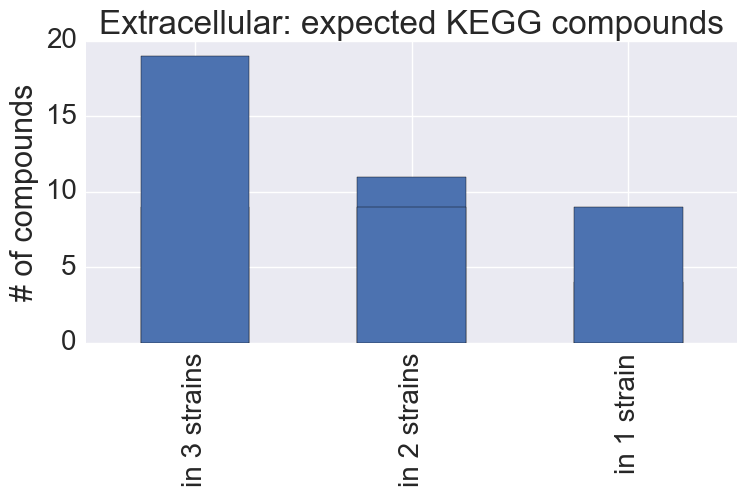

In [83]:
#remember - this is the subset of compounds I expect to find in all three strains...
#also...pre-screened to only be compounds we measured...this figure accounts for 
#anything with a value > 0
fig,axs = plt.subplots(1,1)
sumCount_released.loc[['in3','in2','in1']].plot(kind = 'bar')

sumCount.loc[['in3','in2','in1']].plot(kind = 'bar')
axs.set_title('Extracellular: expected KEGG compounds')
axs.set_ylabel('# of compounds')
tLabel = ['in 3 strains','in 2 strains','in 1 strain']
axs.set_xticklabels(tLabel)
plt.tight_layout()
plt.savefig('nCompounds_extracellular.jpg')

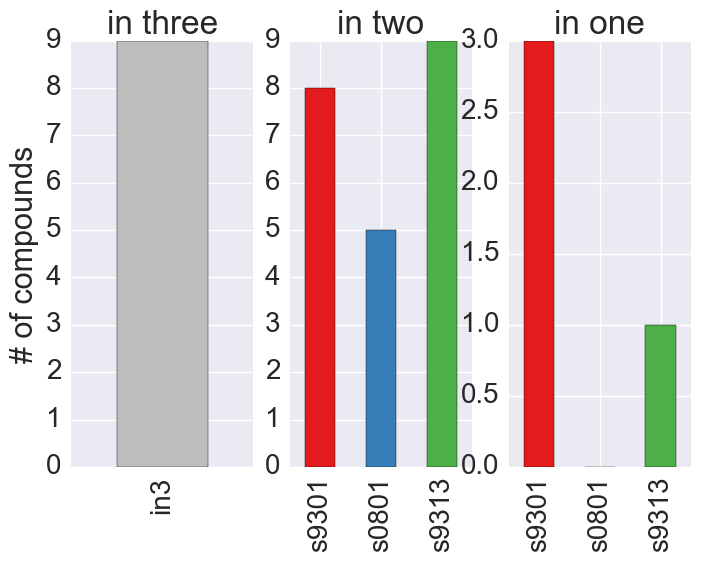

In [84]:
#count up the subsets for plotting (messy); extracellular
efi = released_inNstrains[released_inNstrains.loc[:,'in2']==1]
e_countSub = efi.sum(axis=0)

efi1 = released_inNstrains[released_inNstrains.loc[:,'in1']==1]
e_countSub1 = efi1.sum(axis=0)

useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors

fig,axs = plt.subplots(1,3)
sumCount_released.loc[['in3']].plot(kind = 'bar',ax=axs[0],color = '#bdbdbd')
axs[0].set_title('in three')
axs[0].set_ylabel('# of compounds')

e_countSub.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title('in two')
e_countSub1.loc[pStrains].plot(kind = 'bar',color = useColors,ax=axs[2])
axs[2].set_title('in one')
fig.savefig('compoundsSBin3_extracellular.jpg')

In [85]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s0801']):
        pass
    else:
        #is in the list for strain?
        if item in prm_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [86]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C19675	(R)-2,3-Dihydroxypropane-1-sulfonate



In [87]:
for item in released_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(released_inNstrains.loc[item,'s9313']):
        pass
    else:
        #is in the list for strain?
        if item in pmt_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00328	L-Kynurenine; 3-Anthraniloyl-L-alanine

cpd:C00385	Xanthine



In [88]:
oneCpd='C00954'
r = kegg_link('pathway',oneCpd).read()
m = trimMap(r)

for item in m:
    print(kegg_list(item).read())

path:map00380	Tryptophan metabolism

path:map01070	Biosynthesis of plant hormones

path:map01100	Metabolic pathways

path:map04075	Plant hormone signal transduction



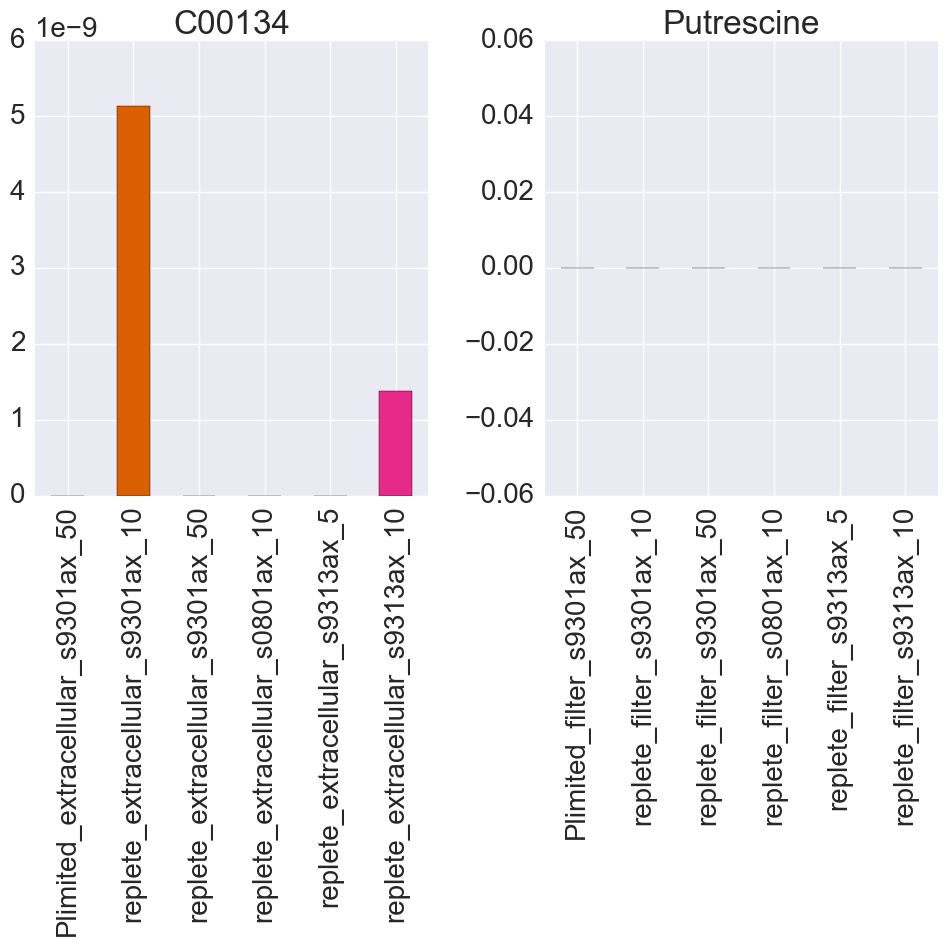

In [89]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
oneCpd = 'C00134'

fig,axs = plt.subplots(1,2)
df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[0])
plt.title(oneCpd)
axs[0].set_title(oneCpd)

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])

if True: #plot?
    #plt.gcf().subplots_adjust(bottom = .75)
    fig.set_size_inches(10,10)
    plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

figure out the ratio of excreted / retained for each metabolite for each strain
---

In [90]:
ratEtoI = pd.DataFrame()
ratItoE = pd.DataFrame()

#for each filter...go find the matching extracellular
for item in list(mtabPruned.filter(regex = ('filter'))):
    #print(item)
    idx = [i for i in range(len(item)) if item.startswith('_',i)]
    toMatch = item[0:idx[0]] + '_extracellular' + item[idx[1]:len(item)]
    label = item[0:idx[0]] + item[idx[1]:len(item)]
    ratItoE.loc[:,label] = mtabPruned.loc[:,item]/mtabPruned.loc[:,toMatch]
    ratEtoI.loc[:,label] = mtabPruned.loc[:,toMatch]/mtabPruned.loc[:,item]      

In [91]:
#deal with Inf and NaN ...though there will be a pile of both which makes the analysis of this hard

In [92]:
temp = ratEtoI.replace(math.nan,0)
ratEtoIpruned = temp.loc[~(temp ==0).all(axis=1)]

In [93]:
temp = ratItoE.replace(math.nan,0)
ratItoEpruned = temp.loc[~(temp ==0).all(axis=1)]

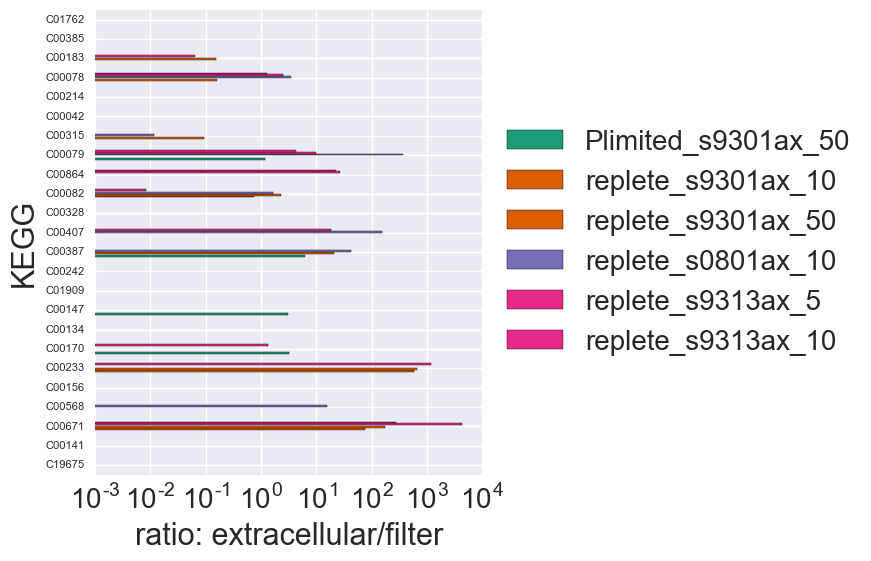

In [94]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']

axs = ratEtoIpruned.plot(kind = 'barh',color= useColors,figsize = (5,6))
#axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_xlabel('ratio: extracellular/filter')
axs.tick_params(axis = 'y',labelsize = 8)
axs.set_xscale('log')
axs.legend(loc = 'center left',bbox_to_anchor = (1,0.5))
# fig.savefig('nCompounds.jpg')
plt.show()

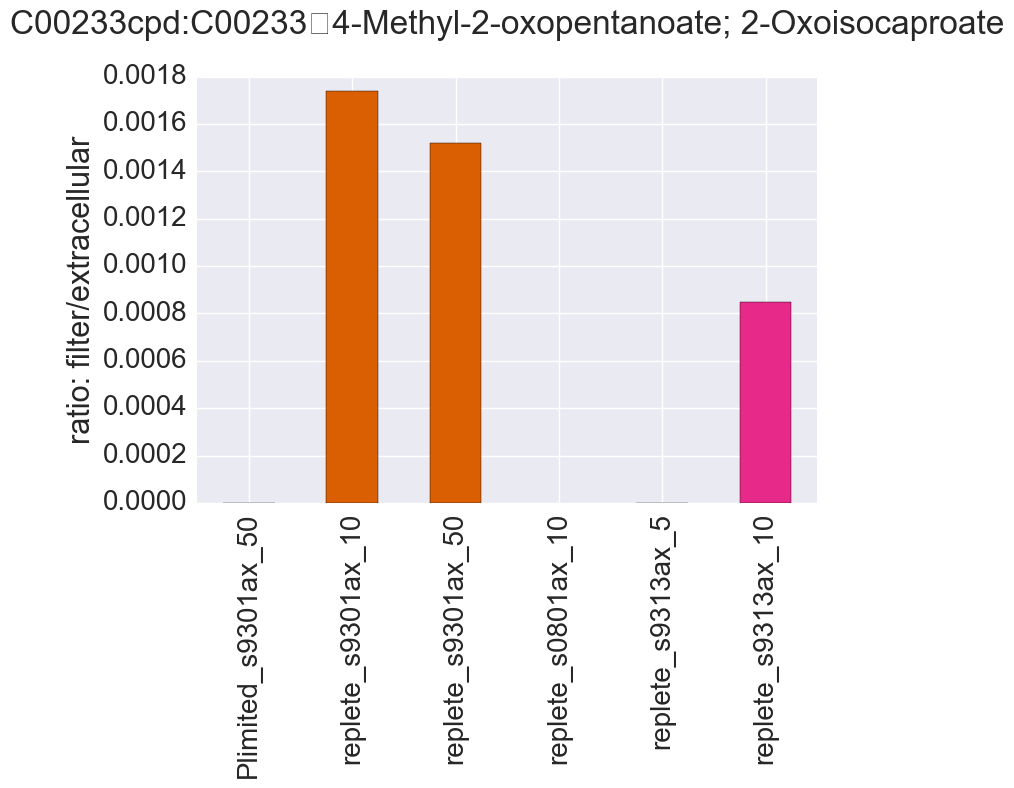

In [95]:
#plot one ratio
oneCpd = 'C00233'

useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = ratItoE.loc[oneCpd].plot(kind = 'bar',color= useColors)
axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('ratio: filter/extracellular')
# fig.savefig('nCompounds.jpg')
plt.show()

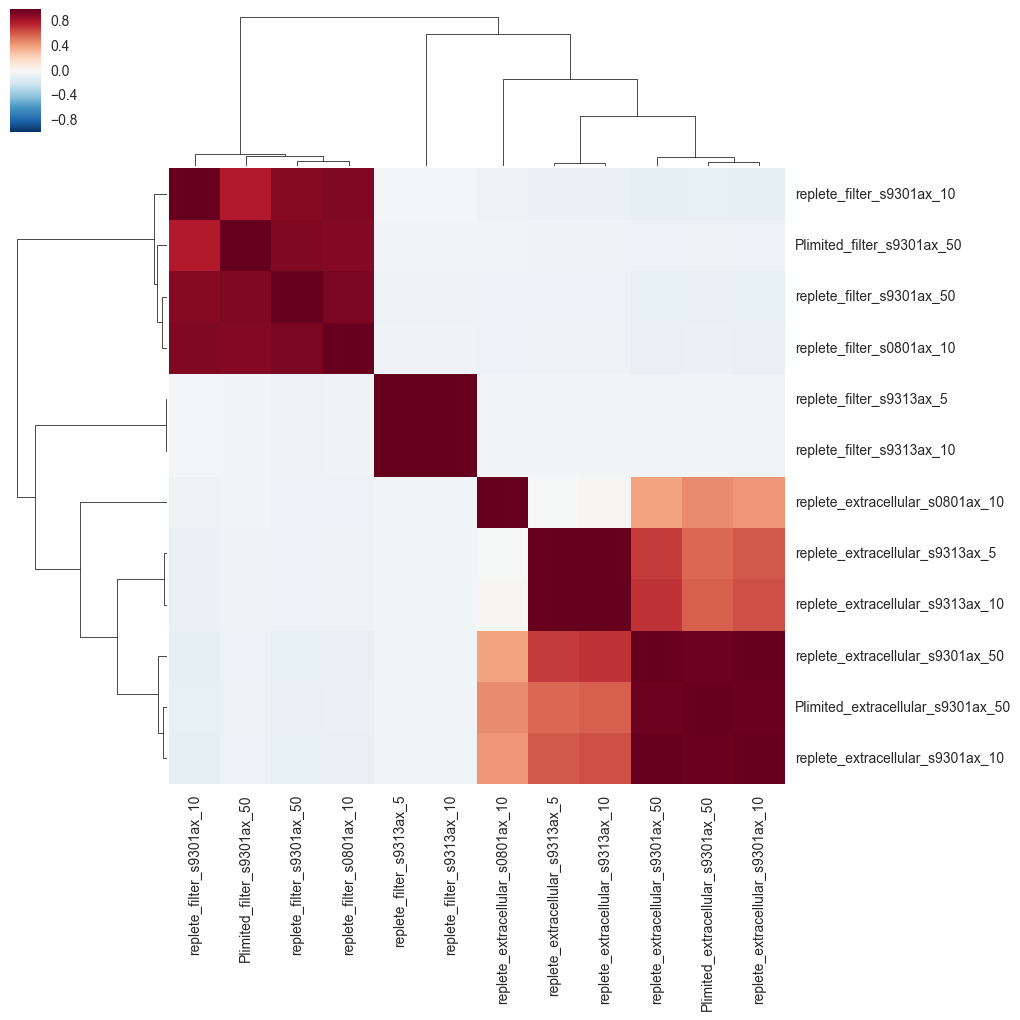

In [96]:
forCorr = mtabPruned.loc[~(mtabPruned ==0).all(axis=1)]
corr = forCorr.corr(method = 'pearson')

sns.set(font_scale=1)
g = sns.clustermap(corr,xticklabels = corr.columns,yticklabels = corr.columns)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
fig = plt.gcf()
#g.savefig('correlationAXsamples.jpg')
plt.show()

Consider how prevalent each compound is within KEGG
---

In [97]:
#already did this in the RI project, just adapt the code to count the compounds in the TSQ data set

In [98]:
countReactions = pd.DataFrame(useCO)
countReactions.insert(1,'nReactions',"")
countReactions.insert(1,'nPathways',"")

In [99]:
for idx in range(0,len(countReactions)):
    oneCpd = countReactions.ix[idx,'KEGG']
    rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
    countReactions.ix[idx,'nReactions'] = len(rnList.splitlines())
    
    #now go count the pathways
    rnList = kegg_link('pathway',oneCpd).read()
    countReactions.ix[idx,'nPathways'] = len(rnList.splitlines())

In [100]:
countReactions.sort_values(by = 'nReactions',ascending = False,inplace = True)
countReactions.reset_index(drop=True,inplace = True)
countReactions.head(4)

KEGG nPathways nReactions
0  C00004         4        962
1  C00019        11        473
2  C00021         3        423
3  C00026        35        244

In [101]:
#investigate one compound
oneCpd = 'C00004'

In [102]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('pathway',oneCpd).read() #now go get the compounds for that reaction
print(len(rnList.splitlines()))

4


In [103]:
#how many pathways? #or, linked to how many genes?
rnList = kegg_link('reaction',oneCpd).read() #now go get the compounds for that reaction
print(len(rnList.splitlines()))

962


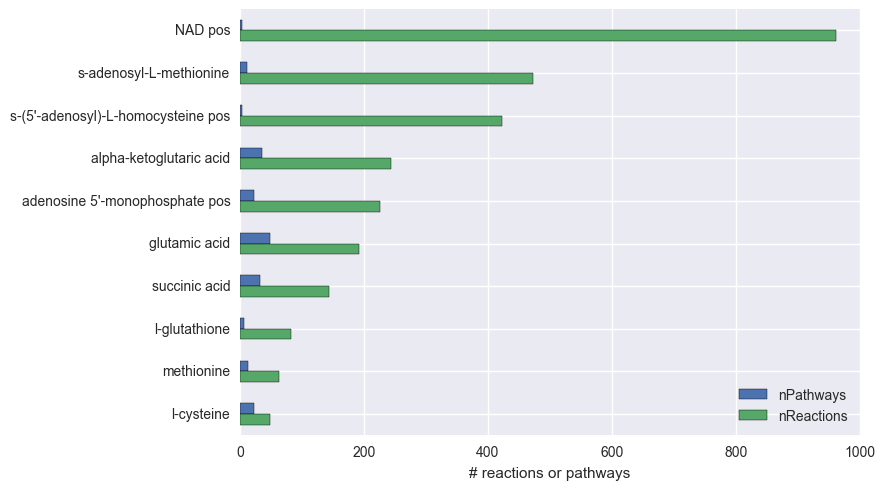

In [104]:
use = range(0,10)
labels = countReactions.ix[use,'KEGG']
tData = countReactions.ix[use]
#ax = tData.plot(kind = 'barh',x = tData['KEGG'])
axs = tData.plot(kind = 'barh',x = mtabNames.loc[tData.loc[:,'KEGG'],'mtabNames'])
fig = plt.gcf()
plt.xlabel('# reactions or pathways')
plt.ylabel('')
plt.gca().invert_yaxis()
plt.savefig('Pro_topTen.png',bbox_inches='tight')

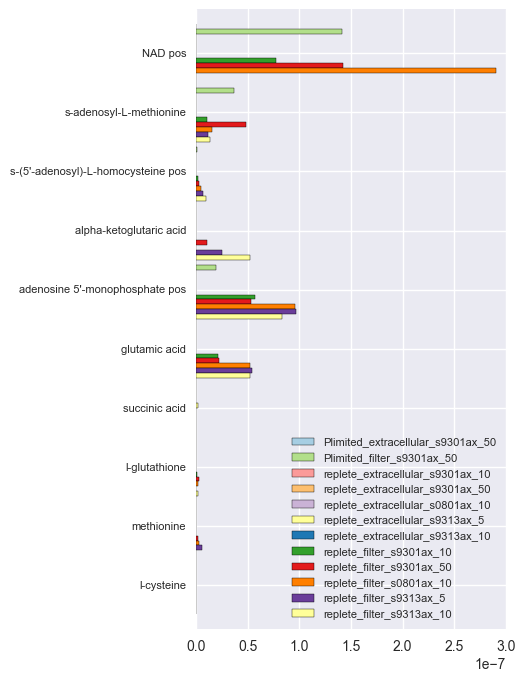

In [105]:
#plot filters and extracellular for the top 10 mtabs
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

axs = mtabPruned.loc[labels].plot(kind = 'barh',color= useColors,figsize = (4,8),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
# fig.savefig('nCompounds.jpg')
#axs.legend(loc = 'center right',bbox_to_anchor = (2,0.5))
plt.legend(loc=0,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

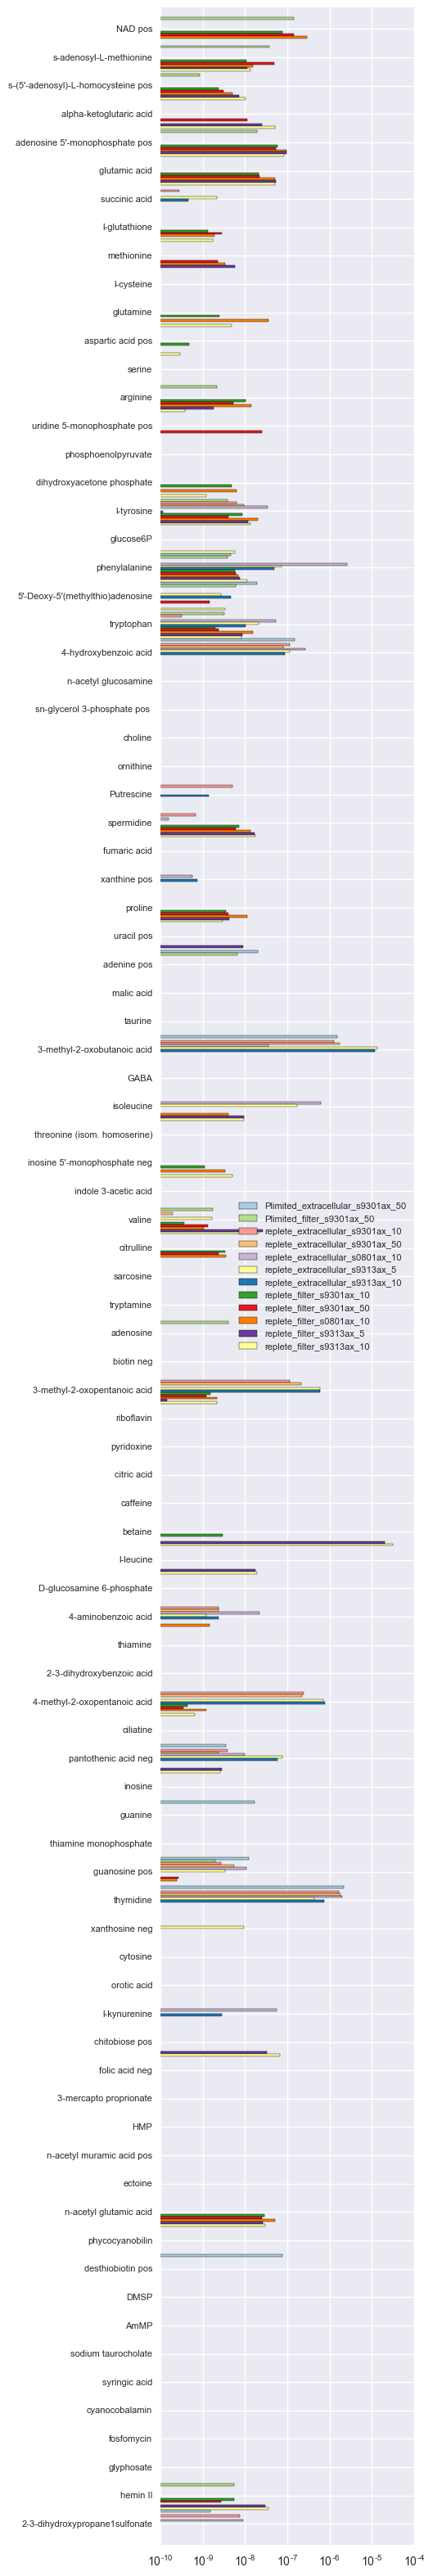

In [106]:
#...plot all (crazy large figure)
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,89)
labels = countReactions.ix[use,'KEGG']

axs = mtabPruned.loc[labels].plot(kind = 'barh',color= useColors,figsize = (4,40),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
#axs.legend(loc = 'center right',bbox_to_anchor = (2,0.5))
plt.legend(loc=0,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

step1 = mtabPruned.filter(regex = ('filter_'))

In [107]:
#filter data only
step1 = mtabPruned.filter(regex = ('filter_'))
tS = step1.sum(axis=1)
idx = tS[tS>0]
toPlot = step1.loc[idx.index,:]

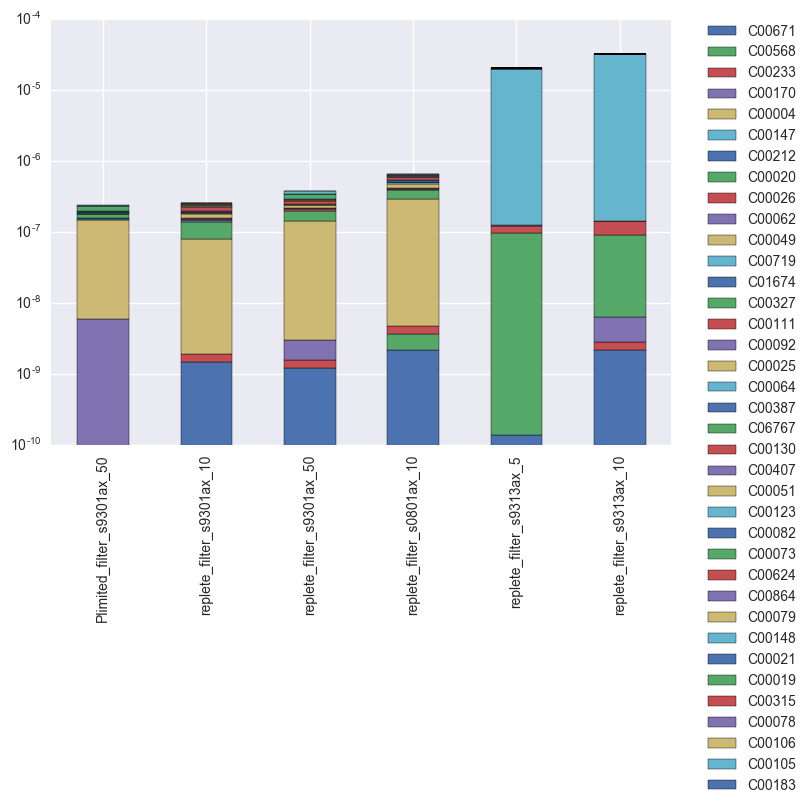

In [108]:
#make stacked bar plot...too many compounds bc not enough colors
# tS = step1.sum(axis=1)
# idx = tS[tS>0]
toPlot = step1.loc[idx.index,:].T

axs = toPlot.plot(kind = 'bar',stacked = True)
# axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# # axs.set_title(oneCpd + kegg_list(oneCpd).read())
# axs.set_ylabel('')
axs.set_yscale('log')
# fig.savefig('stackedBarPlot.jpg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.gca().invert_yaxis()
# plt.show()
plt.savefig('stackedBarPlot.jpg',bbox_inches='tight')

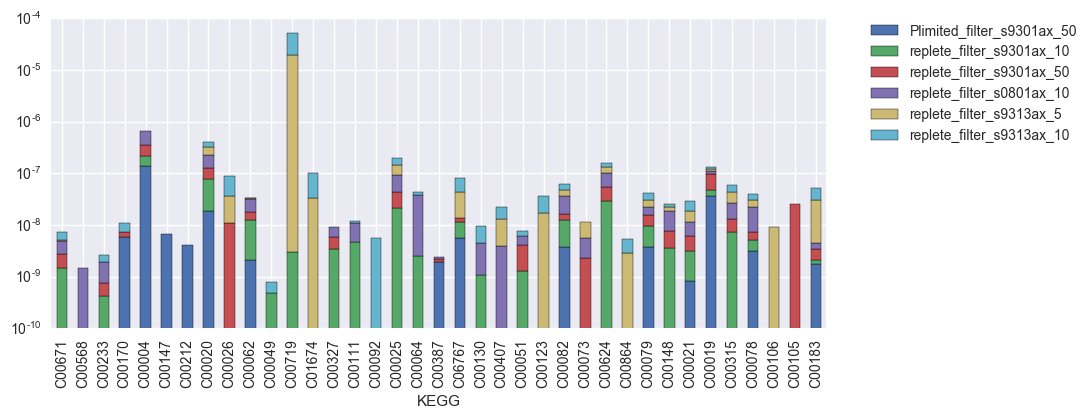

In [109]:
#another version
tS = step1.sum(axis=1)
idx = tS[tS>0]
toPlot = step1.loc[idx.index,:]

axs = toPlot.plot(kind = 'bar',figsize = (10,4), stacked = True)
# axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# # axs.set_title(oneCpd + kegg_list(oneCpd).read())
# axs.set_ylabel('')
axs.set_yscale('log')
# fig.savefig('stackedBarPlot.jpg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.gca().invert_yaxis()
# plt.show()
plt.savefig('temp.jpg',bbox_inches='tight')

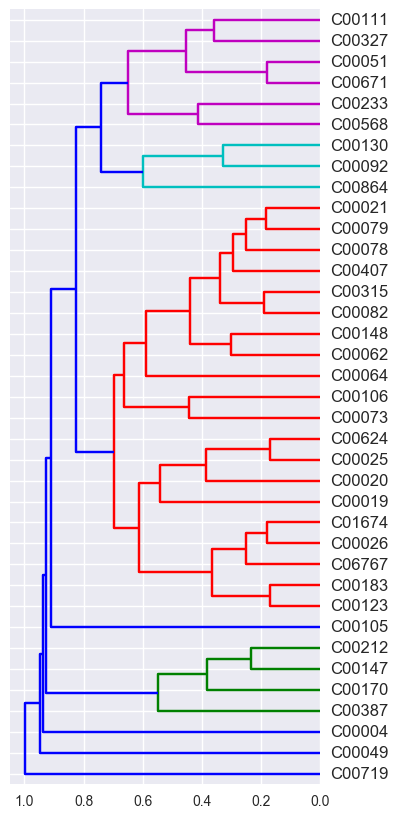

In [110]:
#dendrogram first: these are raw data
z = hc.linkage(toPlot, method='average', metric='braycurtis')
dendrogram = hc.dendrogram(z,labels = toPlot.index,orientation='left')
ax = plt.gca()
ax.tick_params(axis = 'y',which = 'major',labelsize = 12)
fig = plt.gcf()
fig.set_size_inches(4,10)
fig.savefig('dendrogram_vertical.jpg',bbox_inches='tight')
# plt.show()

##could also plot some sort of normalized data
# df = toPlot
# toPlot_norm = (df - df.min()) / (df.max() - df.min())

In [111]:
#get the order from the dendrogram...will use for the bar graph
cOrder = dendrogram['ivl']
shufflePlot = toPlot.loc[cOrder,:]

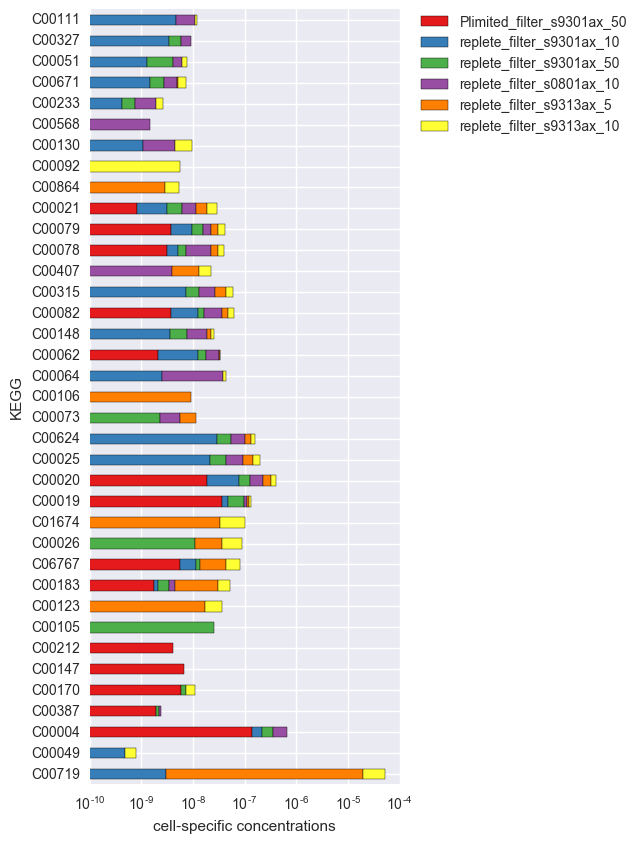

In [112]:
#useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a'] #shows different light as same color
useColors = pal.colorbrewer.qualitative.Set1_6.hex_colors

axs = shufflePlot.plot(kind = 'barh',figsize = (4,10), stacked = True,color = useColors)
# axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# # axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_xlabel('cell-specific concentrations')
axs.set_xscale('log')
# fig.savefig('stackedBarPlot.jpg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.gca().invert_yaxis()
# plt.show()
#plt.savefig('stackedBarPlot_vertical.jpg',bbox_inches='tight')

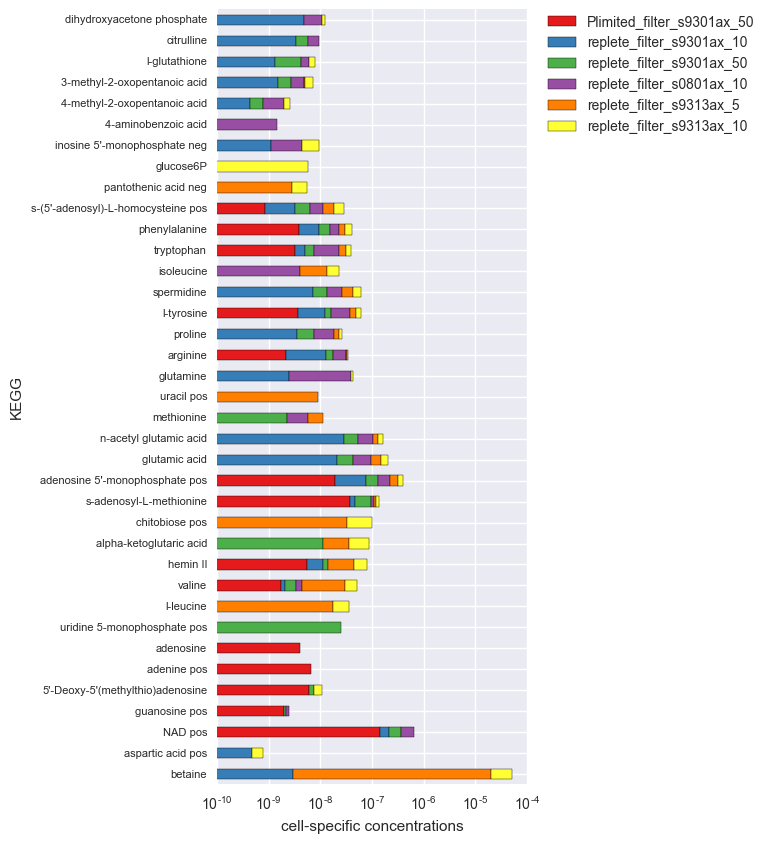

In [113]:
#useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a'] #shows different light as same color
useColors = pal.colorbrewer.qualitative.Set1_6.hex_colors

axs = shufflePlot.plot(kind = 'barh',figsize = (4,10), stacked = True,color = useColors)
axs.set_yticks(np.arange(shufflePlot.shape[0]))
axs.set_yticklabels(mtabNames.loc[shufflePlot.index,'mtabNames'],fontsize = 8)
# # axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_xlabel('cell-specific concentrations')
axs.set_xscale('log')
# fig.savefig('stackedBarPlot.jpg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.gca().invert_yaxis()
# plt.show()
#plt.savefig('stackedBarPlot_vertical.jpg',bbox_inches='tight')

In [114]:
##only do the replete filters...

In [115]:
#filter data only
step1 = mtabPruned.filter(regex = ('replete_filter_'))

tS = step1.sum(axis=1)
idx = tS[tS>0]
toPlot = step1.loc[idx.index,:]



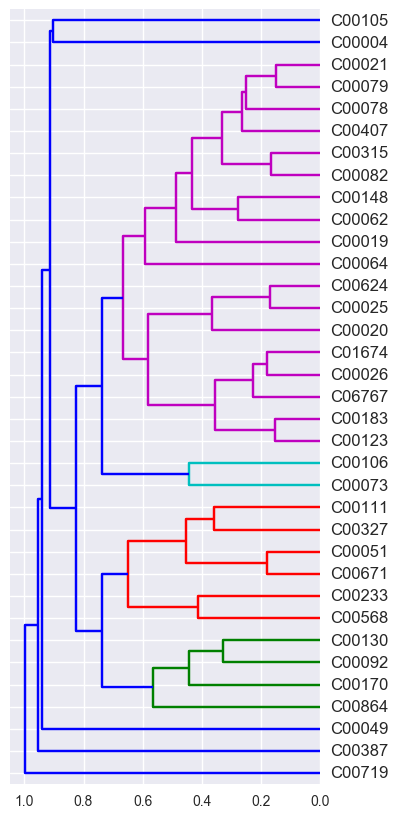

In [116]:
#dendrogram first: these are raw data
z = hc.linkage(toPlot, method='average', metric='braycurtis')
dendrogram = hc.dendrogram(z,labels = toPlot.index,orientation='left')
ax = plt.gca()
ax.tick_params(axis = 'y',which = 'major',labelsize = 12)
fig = plt.gcf()
fig.set_size_inches(4,10)
fig.savefig('dendrogram_vertical.jpg',bbox_inches='tight')
# plt.show()

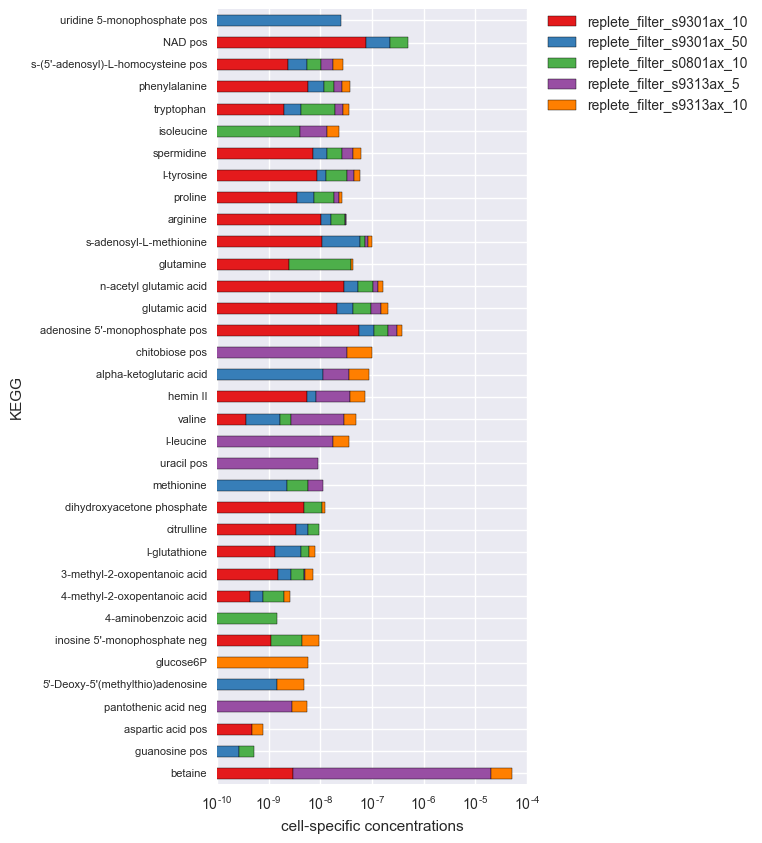

In [117]:
#get the order from the dendrogram...will use for the bar graph
cOrder = dendrogram['ivl']
shufflePlot = toPlot.loc[cOrder,:]

#useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a'] #shows different light as same color
useColors = pal.colorbrewer.qualitative.Set1_6.hex_colors

axs = shufflePlot.plot(kind = 'barh',figsize = (4,10), stacked = True,color = useColors)
axs.set_yticks(np.arange(shufflePlot.shape[0]))
axs.set_yticklabels(mtabNames.loc[shufflePlot.index,'mtabNames'],fontsize = 8)
# # axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_xlabel('cell-specific concentrations')
axs.set_xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('stackedBarPlot_vertical_replete_filter.jpg',bbox_inches='tight')


In [118]:
#can make the same sets figure for extracellular
step1 = mtabPruned.filter(regex = ('extracellular_'))
tS = step1.sum(axis=1)
idx = tS[tS>0]
toPlot = step1.loc[idx.index,:]

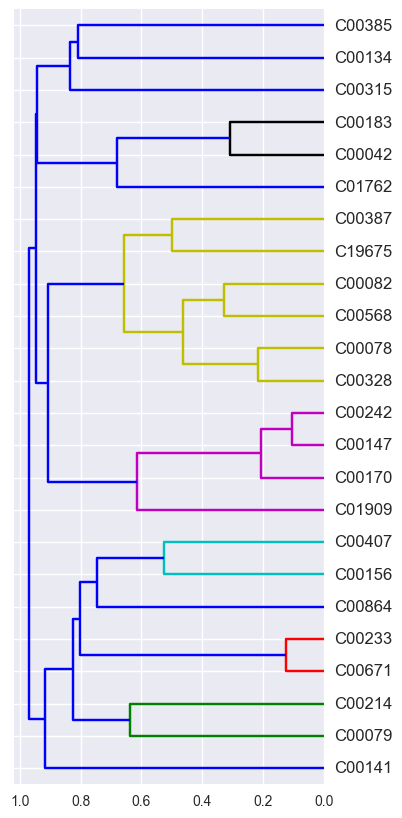

In [119]:
#dendrogram first
z = hc.linkage(toPlot, method='average', metric='braycurtis')
dendrogram = hc.dendrogram(z,labels = toPlot.index,orientation='left')
ax = plt.gca()
ax.tick_params(axis = 'y',which = 'major',labelsize = 12)
fig = plt.gcf()
fig.set_size_inches(4,10)
fig.savefig('dendrogram_vertical_extracellular.jpg',bbox_inches='tight')
# plt.show()

In [120]:
#get the order from the dendrogram...will use for the bar graph
cOrder = dendrogram['ivl']
shufflePlot = toPlot.loc[cOrder,:]

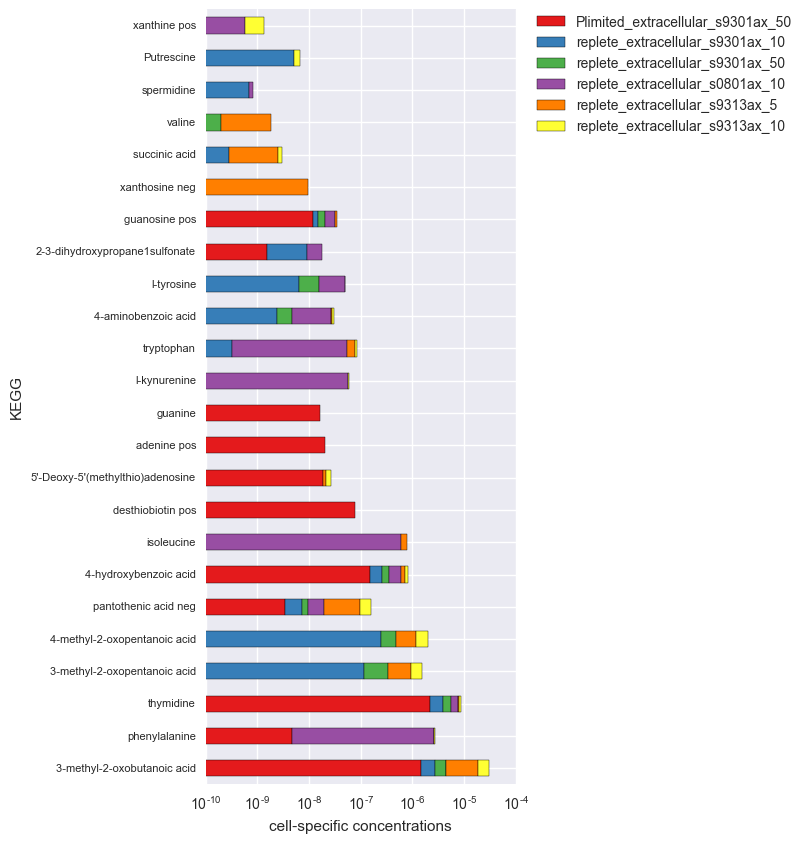

In [121]:
#useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a'] #shows different light as same color
useColors = pal.colorbrewer.qualitative.Set1_6.hex_colors

axs = shufflePlot.plot(kind = 'barh',figsize = (4,10), stacked = True,color = useColors)
axs.set_yticks(np.arange(shufflePlot.shape[0]))
axs.set_yticklabels(mtabNames.loc[shufflePlot.index,'mtabNames'],fontsize = 8)
# # axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_xlabel('cell-specific concentrations')
axs.set_xscale('log')
# fig.savefig('stackedBarPlot.jpg')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.gca().invert_yaxis()
# plt.show()
plt.savefig('stackedBarPlot_vertical_extracellular.jpg',bbox_inches='tight')

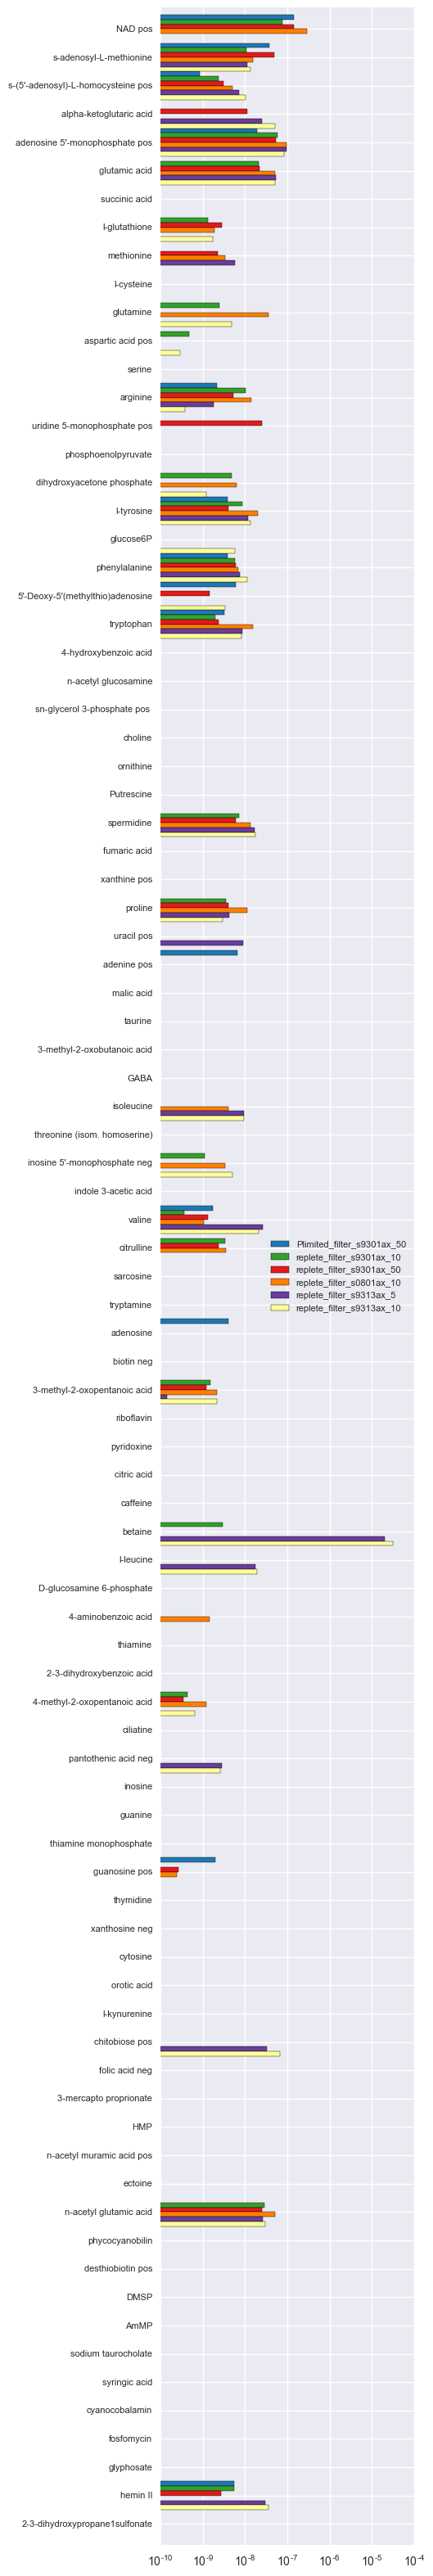

In [122]:
#...just plot the filter data
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,89)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('filter_'))

axs = toPlot.plot(kind = 'barh',color= useColors[6:12],figsize = (4,40),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

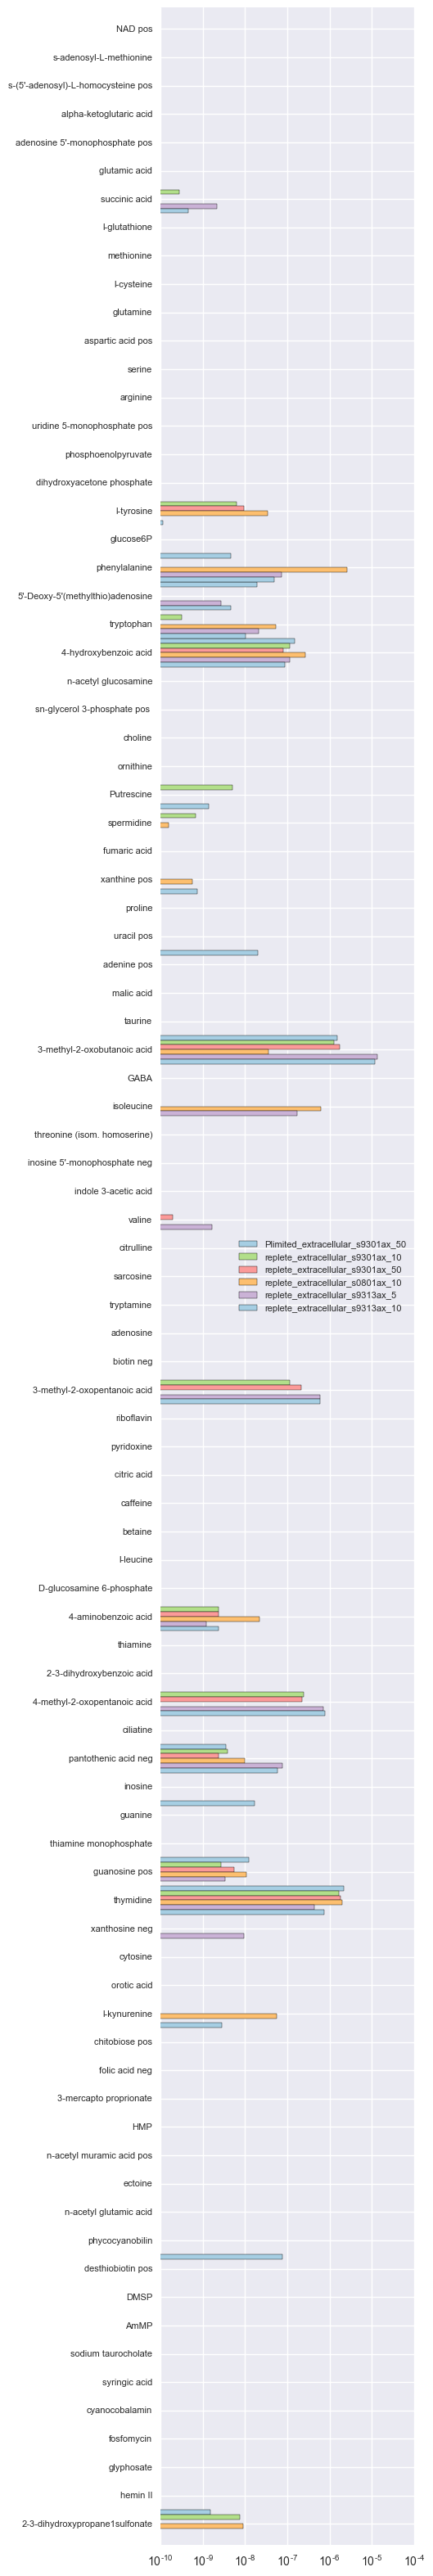

In [123]:
#this is not the best test bc bias in extraction efficiency
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,89)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('extracellular_'))

axs = toPlot.plot(kind = 'barh',color= useColors[0:5],figsize = (4,40),width=1)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

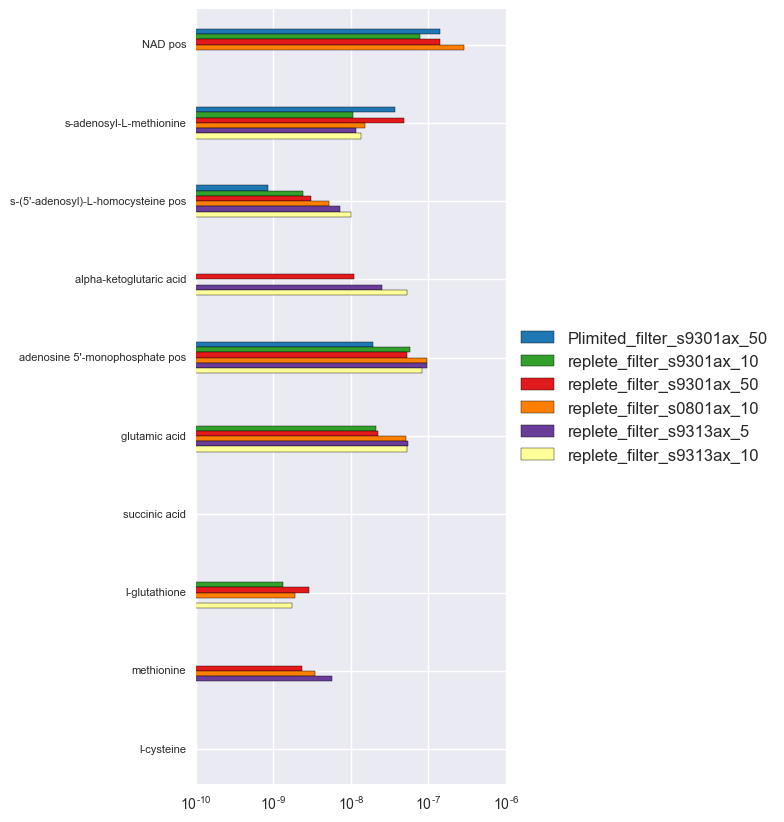

In [124]:
#...such a skew in amounts that most things end up as nothing when plotted as ordered in KEGG
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,10)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('filter_'))

axs = toPlot.plot(kind = 'barh',color= useColors[6:12],figsize = (4,10),width=0.4)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
axs.legend(loc = 'center left',bbox_to_anchor = (1,0.5),fontsize = 12)

#plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

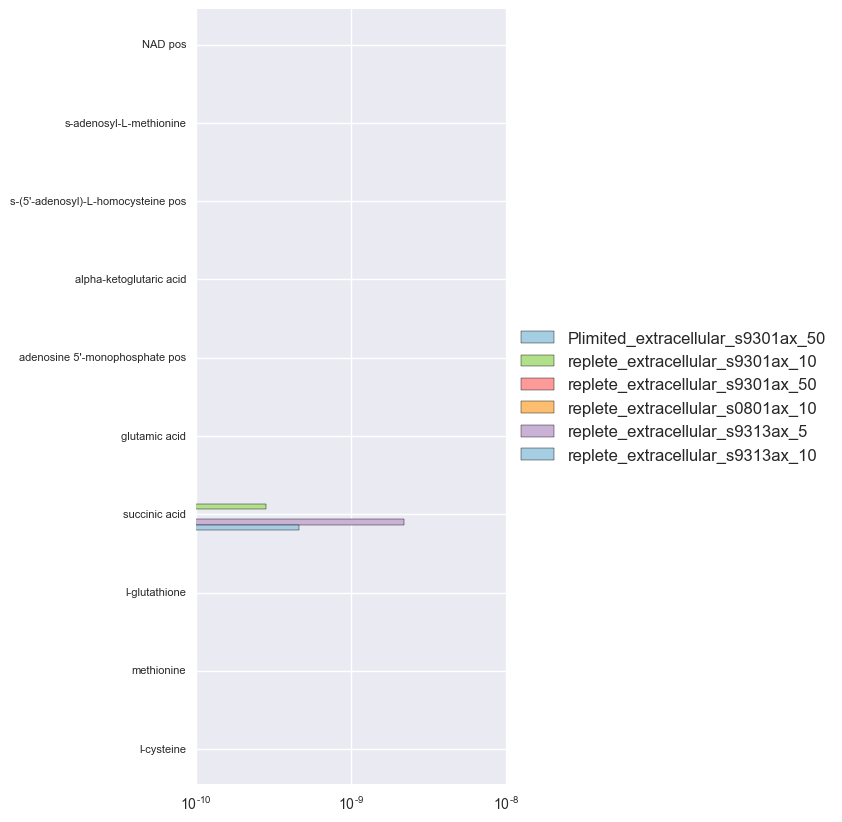

In [125]:
#...such a skew in amounts that most things end up as nothing when plotted as ordered in KEGG
t = pal.colorbrewer.qualitative.Paired_12.hex_colors
useColors = t[:]
useColors[0:5] = t[::2]
useColors[6:11] = t[1:11:2]

use = range(0,10)
labels = countReactions.ix[use,'KEGG']


toPlot = mtabPruned.loc[labels].filter(regex = ('extracellular_'))

axs = toPlot.plot(kind = 'barh',color= useColors[0:5],figsize = (4,10),width=0.4)
axs.set_yticklabels(mtabNames.loc[labels,'mtabNames'],fontsize = 8)
# axs.set_title(oneCpd + kegg_list(oneCpd).read())
axs.set_ylabel('')
axs.set_xscale('log')
# fig.savefig('nCompounds.jpg')
axs.legend(loc = 'center left',bbox_to_anchor = (1,0.5),fontsize = 12)

#plt.legend(loc=7,prop={'size':8})
plt.gca().invert_yaxis()
plt.show()

In [126]:
# plot compounds by groups
useCO = mtabPruned.index
    
for item in prunedBRITE['map']:
    #usePathway = 'ko00020' #remember ko or pmg (not map)
    usePathway = 'ko' + item
     
    try: #KEGG does have pathways in BRITE list that are not searchable
        compounds = getCfrom_ko(usePathway) 

        #figure out which ones I have data for...
        setC = set(compounds)
        setT = set(useCO)
        intCompounds = setC.intersection(setT)

        if len(intCompounds)>0:

            fig,axs = plt.subplots(1,2)
            toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'extracellular')
            toPlot.plot(kind = 'barh',color = useColors,ax=axs[0])
            axs[0].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
            axs[0].set_xticklabels(axs[0].get_xticks().tolist(),fontsize = 8)
            axs[0].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
            axs[0].set_ylabel('')
            axs[0].set_title(usePathway,fontsize = 10)

            toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'filter')
            toPlot.plot(kind = 'barh',color = useColors,ax=axs[1])
            axs[1].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
            axs[1].set_xticklabels(axs[1].get_xticks().tolist(),fontsize = 8)
            axs[1].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
            axs[1].set_ylabel('')

            #probably a better way to do this
            tLabel = prunedBRITE[prunedBRITE.loc[:,'map']==usePathway[2:7]].reset_index()
            axs[1].set_title(tLabel.ix[0,'C'],fontsize = 10)

            if True: #plot?
                #plt.gcf().subplots_adjust(bottom = .75)
                fig.set_size_inches(10,5)
                plt.tight_layout()
                plt.savefig('pathways_withCompounds/' + usePathway + '.png')
                plt.close()
    except:
        print(usePathway + ': in BRITE, but not searchable at KEGG')

ko00351: in BRITE, but not searchable at KEGG
ko01010: in BRITE, but not searchable at KEGG
ko01060: in BRITE, but not searchable at KEGG
ko01061: in BRITE, but not searchable at KEGG
ko01062: in BRITE, but not searchable at KEGG
ko01063: in BRITE, but not searchable at KEGG
ko01064: in BRITE, but not searchable at KEGG
ko01065: in BRITE, but not searchable at KEGG
ko01066: in BRITE, but not searchable at KEGG
ko01070: in BRITE, but not searchable at KEGG
ko07011: in BRITE, but not searchable at KEGG
ko07012: in BRITE, but not searchable at KEGG
ko07013: in BRITE, but not searchable at KEGG
ko07021: in BRITE, but not searchable at KEGG
ko07019: in BRITE, but not searchable at KEGG
ko07020: in BRITE, but not searchable at KEGG
ko07014: in BRITE, but not searchable at KEGG
ko07023: in BRITE, but not searchable at KEGG
ko07026: in BRITE, but not searchable at KEGG
ko07044: in BRITE, but not searchable at KEGG
ko07053: in BRITE, but not searchable at KEGG
ko07040: in BRITE, but not searcha

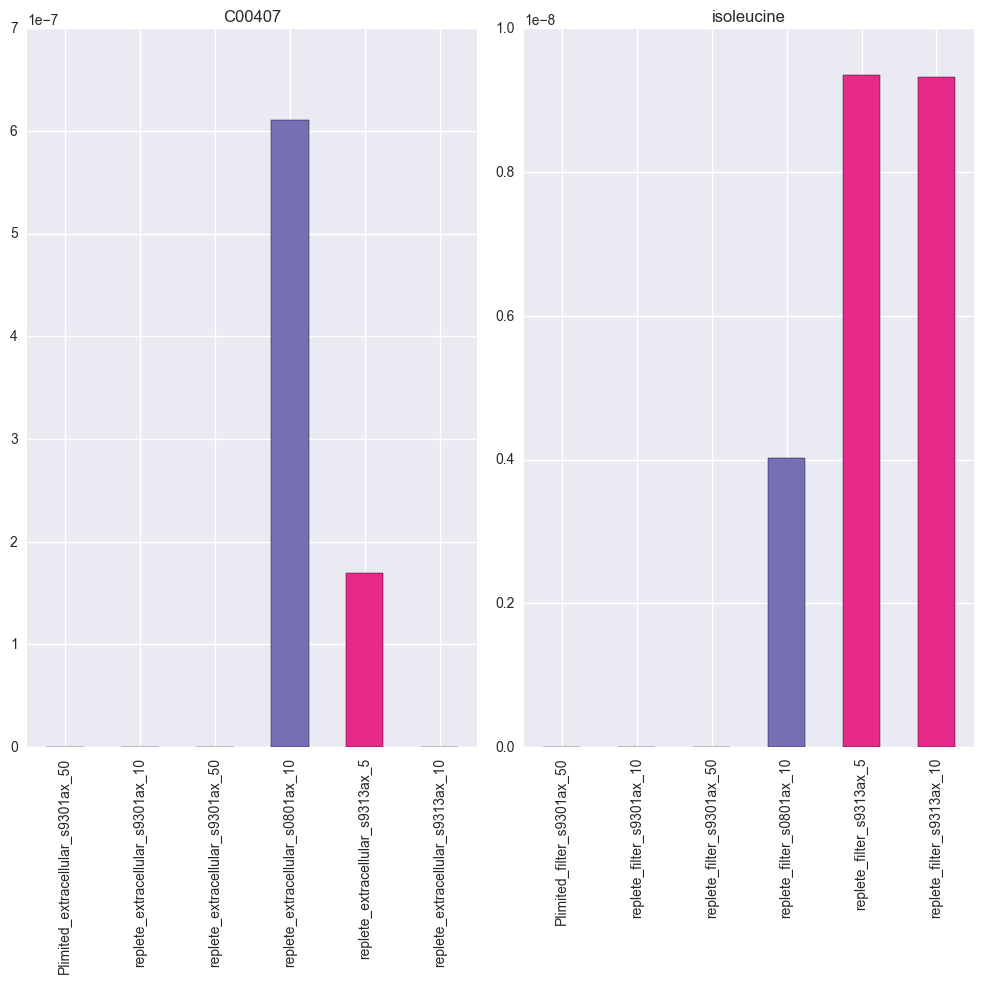

In [127]:
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
oneCpd = 'C00407'

fig,axs = plt.subplots(1,2)
df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[0])
plt.title(oneCpd)
axs[0].set_title(oneCpd)

df2 = mtabPruned.filter(regex = 'filter')
toPlot = df2.loc[oneCpd]
toPlot.plot(kind = 'bar',color = useColors,ax=axs[1])
axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])

if True: #plot?
    #plt.gcf().subplots_adjust(bottom = .75)
    fig.set_size_inches(10,10)
    plt.tight_layout()
    #plt.savefig(oneCpd + '.png')

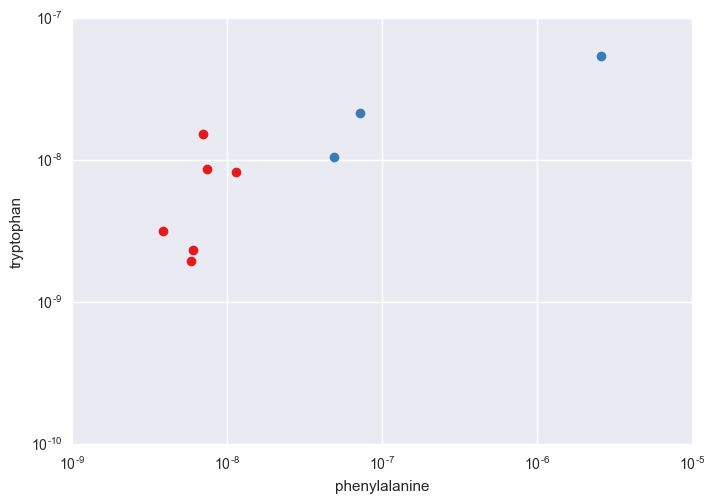

In [128]:
#consider specific pairs of compounds
cpd_phe = 'C00079'
cpd_tyr = 'C00082'
cpd_trp = 'C00078'

a = mtabPruned.loc[cpd_tyr,:]
b = mtabPruned.loc[cpd_phe,:]
c = mtabPruned.loc[cpd_trp,:]

twoColors = ['#e41a1c','#377eb8']

fig,axs = plt.subplots()
plt.plot(b.filter(regex = 'filter'),c.filter(regex = 'filter'),'o',color = twoColors[0])
plt.plot(b.filter(regex = 'extracellular'),c.filter(regex = 'extracellular'),'o',color = twoColors[1])

axs.set_xscale('log')
axs.set_xlabel(mtabNames.loc[cpd_phe,'mtabNames'])

axs.set_yscale('log')
axs.set_ylabel(mtabNames.loc[cpd_trp,'mtabNames'])

plt.show()

In [129]:
import dill                            #pip install dill --user
filename= 'globalsave.pkl'
dill.dump_session(filename)

In [130]:
# leave debris below here for now, notebook will stop at the 'raise' 
# command in the next cell to keep me from running cells 
# of code that are not meant to be connected
raise

RuntimeError: No active exception to reraise

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
import dill
# and to load the session again:
dill.load_session('globalsave.pkl')

In [ ]:
#make one bar graph for each pathway map...with all five sample sets (10 ? )

In [ ]:
from matplotlib.ticker import FuncFormatter

def tickformat(x):
    if int(x) == float(x):
        return str(int(x))
    else:
        return str(x) 
    
fmt = FuncFormatter(lambda x, pos: tickformat(x / 1))

In [ ]:
# #can plot one at a time
# useCO = mtabPruned.index
# #these are the data (or ratios to plot...)
# CO_values = mtabPruned.loc[:,'replete_filter_s9301ax_50']
# fxn_plotPathway_v2.gatherDetails('pmg00410','testingFolder',useCO,CO_values)
useCO = mtabPruned.index
    
item = '00020'
#print(item)
#usePathway = 'ko00020' #remember ko or pmg (not map)
usePathway = 'ko' + item

#get the compounds 
compounds = getCfrom_ko(usePathway)

#figure out which ones I have data for...
setC = set(compounds)
setT = set(useCO)
intCompounds = setC.intersection(setT)

if len(intCompounds)>0:

    fig,axs = plt.subplots(1,2)
    toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'extracellular')
    toPlot.plot(kind = 'barh',color = useColors,ax=axs[0])
    #plt.title(oneCpd)
    #axs[0].set_title(oneCpd)
    axs[0].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
    axs[0].set_xticklabels(axs[0].get_xticks().tolist(),fontsize = 8)
    axs[0].xaxis.set_major_formatter(fmt) #from stackoverflow
    axs[0].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
    axs[0].set_ylabel('')
    axs[0].set_title(usePathway,fontsize = 10)
    axs[0].set_xlabel('cell-specific concentration (ng/cell)',fontsize=8)

    toPlot = mtabPruned.loc[intCompounds,:].filter(regex = 'filter')
    toPlot.plot(kind = 'barh',color = useColors,ax=axs[1])
    #axs[1].set_title(mtabNames.loc[oneCpd,'mtabNames'])
    axs[1].set_yticklabels(mtabNames.loc[intCompounds,'mtabNames'],fontsize = 8)
    axs[1].set_xticklabels(axs[1].get_xticks().tolist(),fontsize = 8)
    axs[1].xaxis.set_major_formatter(fmt)
    axs[1].legend(loc = 'center right',bbox_to_anchor = (1,0.5),fontsize=8)
    axs[1].set_ylabel('')

    #probably a better way to do this
    tLabel = prunedBRITE[prunedBRITE.loc[:,'map']==usePathway[2:7]].reset_index()
    axs[1].set_title(tLabel.ix[0,'C'],fontsize = 10)

    if True: #plot?
        #plt.gcf().subplots_adjust(bottom = .75)
        fig.set_size_inches(10,5)
        plt.tight_layout()
        plt.savefig('pathways_withCompounds/' + usePathway + '.png')
        #plt.close()

In [ ]:
#test one...checking the data
oneCpd = 'C00156'

df2 = mtabPruned.filter(regex = 'extracellular')
toPlot = df2.loc[oneCpd]
useColors = ['#1b9e77','#d95f02','#d95f02','#7570b3','#e7298a','#e7298a']
axs = toPlot.plot(kind = 'bar',color = useColors)
axs.set_title(oneCpd)

if False: #plot?
    plt.savefig('fig.png',bbox_inches='tight') 
    #plt.tight_layout()
    #plt.savefig(oneCpd + '.png')